In [1]:
shape_cat=""
vol=""
z_range=""
key=""
quantile=""
test=""
z_diff=""

In [2]:
# Parameters
shape_cat = "mcal"
vol = "uber"
z_range = "all_z"
key = ""
quantile = ""
test = "foreground"
z_diff = 0.05


In [3]:
#This header file contains all the common packages
%matplotlib inline
%run /home/cz136/project/sa/lib/src/header.py $shape_cat $vol $z_range 
%run -i /home/cz136/project/sa/lib/src/func.py  

In [4]:
z_diff=float(z_diff)

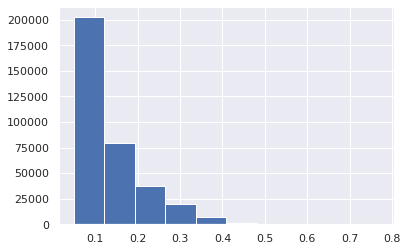

In [5]:
if test=="foreground":
    members=shapes[(shapes[('All','Z')]-shapes[('All','ZRED2')])>=z_diff]
    diff=members[('All','Z')]-members[('All','ZRED2')]
    diff.hist()
    diff.describe()
    
elif test=="background":
    members=background=shapes[(shapes[('All','Z')]-shapes[('All','ZRED2')])<=-z_diff]
    diff=members[('All','Z')]-members[('All','ZRED2')]
    diff.hist()
    diff.describe()
elif test=="":
    members=shapes
else:
    raise TypeError

In [6]:
if vol!="uber":
    members=shapes

In [7]:
if quantile!="":
    i=int(quantile)

In [8]:
if key=="lambda":
    key=('All','All','LAMBDA_CHISQ')
elif key=="z":
    key=('All','All','Z_LAMBDA')

In [9]:
def thirds_by_key(catalog,key):
    step0=catalog[key].quantile(0.0)
    step1=catalog[key].quantile(0.333333)
    step2=catalog[key].quantile(0.666666)
    step3=catalog[key].quantile(1)
    
    catalog1=catalog[(catalog[key]>step0) & (catalog[key]<step1)]
    catalog2=catalog[(catalog[key]>step1) & (catalog[key]<step2)]
    catalog3=catalog[(catalog[key]>step2) & (catalog[key]<step3)]
    
    return (catalog1,catalog2,catalog3)

In [10]:
if key!="":
    clusters_list=thirds_by_key(clusters,key)
    clusters=clusters_list[i]

In [11]:
sep="------------------------------------------------------------------------------"
np.set_printoptions(precision=4)

In [12]:
NBINS=10

In [13]:
import treecorr
import astropy.cosmology
from fastprogress import master_bar, progress_bar
from ipywidgets import FloatProgress
from IPython.display import display
from tqdm import tqdm

In [14]:
len(shapes)

1079244

In [15]:
len(members)

347669

In [16]:
if key=="":
    assert np.isin(shapes['All','MEM_MATCH_ID'].to_numpy(),clusters.index.to_numpy()).all()==True

In [17]:
def get_ng(cluster,mode1,mode2):
    if mode2=="abs":
        UPPER_BOUND=np.max(shapes[('All','R')])
        distance=('All','angR')
        
    elif mode2=="rel":
        UPPER_BOUND=1.2
        distance=('All','normLR')
    else:
        raise

    if mode1 == "s":
        def get_cluster_cen(cluster):
            return (get_unique_center_for_cluster(cluster))
        def get_cluster_sats(cluster):
            cen_mat_id=cluster.name
            cen_id=cluster[('Alt','Alt1','ID_CENT')]
            sats=members[members['All','MEM_MATCH_ID']==cen_mat_id]
            sats=sats[sats.index!=cen_id]
            return (sats)
    elif mode1=='r':
        def get_cluster_sats(cluster):
            return(shapes)
        def get_cluster_cen(cluster):
            return (random)

    else:
        raise


    cen=get_cluster_cen(cluster)
    sats=get_cluster_sats(cluster)


    sats_e1=sats[('All','e1')].to_numpy()
    sats_e2=sats[('All','e2')].to_numpy()
    sats_angr=sats[distance]

#     print(sats_e1,sats_e2)

    if type(cen[('All','RA')])==np.float64:
        cen_angr=np.array(cen[distance]).reshape(1)
        cen_ra=np.array(cen[('All','RA')]).reshape(1)
        cen_dec=np.array(cen[('All','DEC')]).reshape(1)
    else:
#         cen_e1=cen[('All','e1')].to_numpy
#         cen_e2=cen[('All','e2')].to_numpy()
        cen_angr=cen[distance].to_numpy()
        cen_ra=cen[('All','RA')].to_numpy()
        cen_dec=cen[('All','DEC')].to_numpy()




#     print(cen_e1,cen_e2)

    sats_ra=sats[('All','RA')].to_numpy()
    sats_dec=sats[('All','DEC')].to_numpy()




#     print(np.shape(cen_ra),np.shape(cen_dec))    
#     print(cen_ra,cen_dec)    

    sats_cat = treecorr.Catalog( g1 = sats_e1, g2   = sats_e2, 
                                 ra = sats_ra, dec = sats_dec,r=sats_angr,
                                 ra_units='deg', dec_units='deg')

    cen_cat = treecorr.Catalog( 
                                 ra = cen_ra, dec = cen_dec, r=cen_angr,
                                 ra_units='deg', dec_units='deg')

    ng = treecorr.NGCorrelation(nbins=NBINS, min_sep=0.01, max_sep=UPPER_BOUND, bin_slop=0.0,
                               metric="Rperp")
    ng.process_cross(cen_cat,sats_cat)

    return(ng)

In [18]:
def get_xi_meanlogr_varxi_npairs(cluster,mode1,mode2):
    ng=get_ng(cluster,mode1,mode2)
    return(np.array([ng.xi,ng.meanlogr,ng.varxi,ng.npairs]))

In [19]:
length=len(clusters)

def get_ng_list(mode2):
    ng_list=np.empty([length,4,NBINS])
    filler=np.zeros([1,4,NBINS])

    i=0
    e_count=0
    for index,cluster in tqdm(clusters.iterrows()):
        try:
            ng_list[i,:,:]=get_xi_meanlogr_varxi_npairs(cluster,'s',mode2)
            i=i+1
        except ValueError as e:
            ng_list[i,:,:]=filler
            i=i+1
            e_count=e_count+1
    print("Number of empty sat catalogs is {}".format(e_count))
    return (ng_list)

In [20]:
ng_abs=get_ng_list('abs')
ng_rel=get_ng_list('rel')

0it [00:00, ?it/s]

1it [00:00,  7.07it/s]

4it [00:00,  9.07it/s]

7it [00:00, 11.30it/s]

10it [00:00, 13.83it/s]

14it [00:00, 16.40it/s]

18it [00:00, 19.25it/s]

21it [00:00, 21.54it/s]

25it [00:00, 23.50it/s]

29it [00:01, 25.30it/s]

32it [00:01, 25.87it/s]

36it [00:01, 27.59it/s]

39it [00:01, 27.93it/s]

42it [00:01, 27.83it/s]

46it [00:01, 28.89it/s]

49it [00:01, 28.71it/s]

53it [00:01, 29.69it/s]

57it [00:02, 30.85it/s]

61it [00:02, 30.02it/s]

65it [00:02, 29.06it/s]

69it [00:02, 30.17it/s]

73it [00:02, 31.60it/s]

77it [00:02, 31.10it/s]

81it [00:02, 32.49it/s]

85it [00:02, 32.99it/s]

89it [00:03, 31.26it/s]

93it [00:03, 30.25it/s]

97it [00:03, 31.80it/s]

101it [00:03, 33.79it/s]

106it [00:03, 35.52it/s]

111it [00:03, 37.66it/s]

115it [00:03, 37.46it/s]

119it [00:03, 35.71it/s]

123it [00:04, 33.19it/s]

127it [00:04, 34.02it/s]

131it [00:04, 33.02it/s]

135it [00:04, 32.38it/s]

139it [00:04, 31.84it/s]

143it [00:04, 31.55it/s]

147it [00:04, 31.69it/s]

151it [00:04, 30.48it/s]

155it [00:05, 30.63it/s]

159it [00:05, 31.32it/s]

163it [00:05, 30.50it/s]

167it [00:05, 30.31it/s]

171it [00:05, 30.45it/s]

175it [00:05, 32.33it/s]

179it [00:05, 32.78it/s]

183it [00:05, 33.16it/s]

187it [00:06, 33.83it/s]

192it [00:06, 35.67it/s]

196it [00:06, 34.68it/s]

200it [00:06, 34.42it/s]

204it [00:06, 34.21it/s]

208it [00:06, 34.81it/s]

212it [00:06, 35.01it/s]

216it [00:06, 34.68it/s]

221it [00:06, 36.51it/s]

225it [00:07, 36.15it/s]

229it [00:07, 37.06it/s]

234it [00:07, 39.92it/s]

239it [00:07, 40.38it/s]

244it [00:07, 38.13it/s]

248it [00:07, 38.01it/s]

252it [00:07, 37.20it/s]

257it [00:07, 39.74it/s]

262it [00:07, 40.45it/s]

267it [00:08, 39.48it/s]

271it [00:08, 39.64it/s]

276it [00:08, 39.73it/s]

280it [00:08, 37.56it/s]

284it [00:08, 35.63it/s]

288it [00:08, 35.08it/s]

292it [00:08, 34.79it/s]

296it [00:08, 35.05it/s]

300it [00:09, 35.47it/s]

304it [00:09, 34.93it/s]

308it [00:09, 34.73it/s]

313it [00:09, 36.24it/s]

318it [00:09, 37.65it/s]

322it [00:09, 36.21it/s]

327it [00:09, 37.82it/s]

332it [00:09, 37.47it/s]

336it [00:10, 37.40it/s]

340it [00:10, 36.72it/s]

344it [00:10, 34.71it/s]

348it [00:10, 35.95it/s]

352it [00:10, 35.79it/s]

356it [00:10, 35.48it/s]

360it [00:10, 35.63it/s]

364it [00:10, 34.33it/s]

368it [00:10, 34.43it/s]

373it [00:11, 35.97it/s]

377it [00:11, 36.93it/s]

381it [00:11, 36.75it/s]

385it [00:11, 36.63it/s]

390it [00:11, 38.27it/s]

394it [00:11, 38.47it/s]

398it [00:11, 37.35it/s]

402it [00:11, 37.18it/s]

406it [00:11, 36.62it/s]

410it [00:12, 35.39it/s]

414it [00:12, 35.22it/s]

418it [00:12, 34.83it/s]

422it [00:12, 35.55it/s]

426it [00:12, 36.25it/s]

430it [00:12, 34.79it/s]

434it [00:12, 34.76it/s]

439it [00:12, 36.34it/s]

443it [00:13, 34.26it/s]

447it [00:13, 34.67it/s]

452it [00:13, 35.78it/s]

456it [00:13, 34.53it/s]

460it [00:13, 32.88it/s]

464it [00:13, 34.41it/s]

469it [00:13, 36.14it/s]

473it [00:13, 34.95it/s]

477it [00:13, 33.40it/s]

481it [00:14, 34.46it/s]

485it [00:14, 32.92it/s]

489it [00:14, 33.90it/s]

493it [00:14, 33.22it/s]

498it [00:14, 35.07it/s]

503it [00:14, 36.98it/s]

507it [00:14, 37.11it/s]

512it [00:14, 37.75it/s]

516it [00:15, 35.35it/s]

520it [00:15, 36.17it/s]

527it [00:15, 41.46it/s]

534it [00:15, 46.56it/s]

540it [00:15, 48.88it/s]

546it [00:15, 47.42it/s]

552it [00:15, 48.09it/s]

557it [00:15, 44.19it/s]

562it [00:16, 40.95it/s]

567it [00:16, 41.58it/s]

572it [00:16, 39.15it/s]

577it [00:16, 39.18it/s]

581it [00:16, 38.90it/s]

585it [00:16, 37.58it/s]

589it [00:16, 36.23it/s]

593it [00:16, 36.43it/s]

597it [00:16, 36.39it/s]

602it [00:17, 38.02it/s]

606it [00:17, 38.35it/s]

610it [00:17, 37.85it/s]

615it [00:17, 39.07it/s]

619it [00:17, 37.41it/s]

623it [00:17, 36.40it/s]

627it [00:17, 33.69it/s]

631it [00:17, 32.52it/s]

635it [00:18, 34.02it/s]

639it [00:18, 33.50it/s]

643it [00:18, 34.33it/s]

647it [00:18, 34.45it/s]

651it [00:18, 35.08it/s]

655it [00:18, 33.90it/s]

659it [00:18, 33.01it/s]

663it [00:18, 34.00it/s]

667it [00:18, 34.24it/s]

671it [00:19, 32.71it/s]

675it [00:19, 33.40it/s]

679it [00:19, 33.36it/s]

683it [00:19, 33.76it/s]

687it [00:19, 32.11it/s]

692it [00:19, 33.98it/s]

696it [00:19, 35.10it/s]

701it [00:19, 37.12it/s]

705it [00:20, 35.22it/s]

709it [00:20, 35.67it/s]

713it [00:20, 35.88it/s]

717it [00:20, 36.15it/s]

721it [00:20, 34.55it/s]

725it [00:20, 32.78it/s]

730it [00:20, 35.03it/s]

734it [00:20, 35.60it/s]

739it [00:21, 37.92it/s]

744it [00:21, 38.66it/s]

749it [00:21, 39.27it/s]

753it [00:21, 36.96it/s]

757it [00:21, 36.85it/s]

762it [00:21, 38.83it/s]

766it [00:21, 38.27it/s]

770it [00:21, 38.14it/s]

774it [00:21, 37.25it/s]

778it [00:22, 37.91it/s]

782it [00:22, 37.49it/s]

786it [00:22, 37.74it/s]

790it [00:22, 37.10it/s]

794it [00:22, 37.66it/s]

798it [00:22, 36.33it/s]

802it [00:22, 34.45it/s]

806it [00:22, 35.07it/s]

810it [00:22, 35.93it/s]

814it [00:23, 36.06it/s]

818it [00:23, 35.78it/s]

822it [00:23, 35.19it/s]

826it [00:23, 35.54it/s]

830it [00:23, 33.53it/s]

834it [00:23, 33.47it/s]

839it [00:23, 35.39it/s]

843it [00:23, 36.65it/s]

847it [00:23, 36.23it/s]

851it [00:24, 35.80it/s]

855it [00:24, 35.06it/s]

859it [00:24, 33.65it/s]

863it [00:24, 32.89it/s]

867it [00:24, 32.40it/s]

871it [00:24, 31.85it/s]

875it [00:24, 32.31it/s]

879it [00:24, 33.16it/s]

883it [00:25, 33.13it/s]

887it [00:25, 32.07it/s]

891it [00:25, 32.12it/s]

895it [00:25, 33.31it/s]

899it [00:25, 33.13it/s]

903it [00:25, 33.56it/s]

910it [00:25, 38.76it/s]

915it [00:25, 39.81it/s]

920it [00:26, 38.65it/s]

925it [00:26, 39.09it/s]

930it [00:26, 37.63it/s]

934it [00:26, 36.04it/s]

938it [00:26, 34.37it/s]

943it [00:26, 36.01it/s]

947it [00:26, 34.64it/s]

951it [00:26, 35.14it/s]

955it [00:27, 34.54it/s]

959it [00:27, 34.48it/s]

963it [00:27, 32.30it/s]

968it [00:27, 34.84it/s]

972it [00:27, 36.06it/s]

977it [00:27, 38.15it/s]

981it [00:27, 35.52it/s]

985it [00:27, 33.37it/s]

989it [00:28, 34.86it/s]

993it [00:28, 35.46it/s]

997it [00:28, 35.29it/s]

1001it [00:28, 35.70it/s]

1005it [00:28, 35.25it/s]

1009it [00:28, 34.43it/s]

1013it [00:28, 35.50it/s]

1017it [00:28, 34.45it/s]

1021it [00:28, 35.78it/s]

1025it [00:29, 35.29it/s]

1030it [00:29, 37.02it/s]

1034it [00:29, 36.80it/s]

1038it [00:29, 34.50it/s]

1042it [00:29, 34.67it/s]

1046it [00:29, 34.15it/s]

1050it [00:29, 34.00it/s]

1054it [00:29, 35.28it/s]

1058it [00:29, 34.71it/s]

1062it [00:30, 35.40it/s]

1066it [00:30, 33.90it/s]

1070it [00:30, 33.86it/s]

1074it [00:30, 35.30it/s]

1078it [00:30, 34.84it/s]

1082it [00:30, 35.23it/s]

1086it [00:30, 33.47it/s]

1090it [00:30, 34.24it/s]

1095it [00:31, 36.49it/s]

1099it [00:31, 34.74it/s]

1103it [00:31, 35.42it/s]

1107it [00:31, 35.40it/s]

1111it [00:31, 36.48it/s]

1115it [00:31, 37.15it/s]

1119it [00:31, 35.01it/s]

1123it [00:31, 34.26it/s]

1127it [00:31, 33.10it/s]

1131it [00:32, 34.80it/s]

1135it [00:32, 34.72it/s]

1139it [00:32, 33.82it/s]

1143it [00:32, 33.39it/s]

1147it [00:32, 33.22it/s]

1151it [00:32, 33.50it/s]

1156it [00:32, 36.00it/s]

1161it [00:32, 37.10it/s]

1166it [00:33, 37.85it/s]

1170it [00:33, 37.49it/s]

1174it [00:33, 38.08it/s]

1178it [00:33, 35.88it/s]

1183it [00:33, 38.99it/s]

1188it [00:33, 39.22it/s]

1192it [00:33, 38.62it/s]

1196it [00:33, 38.45it/s]

1200it [00:33, 37.91it/s]

1204it [00:34, 36.00it/s]

1208it [00:34, 34.82it/s]

1212it [00:34, 34.11it/s]

1217it [00:34, 36.10it/s]

1221it [00:34, 35.82it/s]

1225it [00:34, 34.77it/s]

1229it [00:34, 35.60it/s]

1233it [00:34, 35.55it/s]

1237it [00:34, 35.74it/s]

1241it [00:35, 35.99it/s]

1245it [00:35, 36.28it/s]

1249it [00:35, 34.11it/s]

1253it [00:35, 34.18it/s]

1257it [00:35, 34.21it/s]

1261it [00:35, 32.91it/s]

1266it [00:35, 35.51it/s]

1271it [00:35, 37.83it/s]

1275it [00:36, 35.96it/s]

1279it [00:36, 35.61it/s]

1283it [00:36, 35.85it/s]

1287it [00:36, 34.05it/s]

1292it [00:36, 35.34it/s]

1296it [00:36, 36.34it/s]

1300it [00:36, 36.34it/s]

1304it [00:36, 36.42it/s]

1309it [00:36, 37.43it/s]

1313it [00:37, 37.33it/s]

1317it [00:37, 36.86it/s]

1321it [00:37, 35.00it/s]

1325it [00:37, 35.13it/s]

1329it [00:37, 35.12it/s]

1333it [00:37, 34.71it/s]

1337it [00:37, 33.90it/s]

1342it [00:37, 35.84it/s]

1346it [00:38, 34.13it/s]

1350it [00:38, 33.31it/s]

1354it [00:38, 34.52it/s]

1358it [00:38, 35.18it/s]

1362it [00:38, 36.07it/s]

1366it [00:38, 35.68it/s]

1370it [00:38, 33.28it/s]

1374it [00:38, 33.65it/s]

1379it [00:38, 37.19it/s]

1383it [00:39, 37.19it/s]

1387it [00:39, 36.52it/s]

1391it [00:39, 35.31it/s]

1395it [00:39, 35.21it/s]

1399it [00:39, 33.96it/s]

1403it [00:39, 33.77it/s]

1407it [00:39, 33.35it/s]

1412it [00:39, 35.93it/s]

1416it [00:39, 35.70it/s]

1421it [00:40, 37.59it/s]

1425it [00:40, 35.05it/s]

1429it [00:40, 36.39it/s]

1434it [00:40, 38.16it/s]

1439it [00:40, 39.09it/s]

1443it [00:40, 37.58it/s]

1447it [00:40, 37.82it/s]

1451it [00:40, 37.33it/s]

1455it [00:41, 37.18it/s]

1459it [00:41, 36.49it/s]

1463it [00:41, 33.60it/s]

1468it [00:41, 35.63it/s]

1472it [00:41, 36.27it/s]

1476it [00:41, 36.57it/s]

1480it [00:41, 35.67it/s]

1485it [00:41, 37.29it/s]

1489it [00:41, 37.40it/s]

1493it [00:42, 37.46it/s]

1498it [00:42, 38.36it/s]

1502it [00:42, 35.39it/s]

1506it [00:42, 36.12it/s]

1510it [00:42, 36.94it/s]

1514it [00:42, 37.37it/s]

1519it [00:42, 37.67it/s]

1524it [00:42, 39.57it/s]

1529it [00:42, 39.94it/s]

1534it [00:43, 37.91it/s]

1538it [00:43, 37.96it/s]

1542it [00:43, 37.20it/s]

1546it [00:43, 35.99it/s]

1550it [00:43, 35.20it/s]

1555it [00:43, 37.08it/s]

1559it [00:43, 37.91it/s]

1563it [00:43, 36.93it/s]

1567it [00:44, 37.29it/s]

1571it [00:44, 34.31it/s]

1576it [00:44, 37.01it/s]

1583it [00:44, 42.13it/s]

1588it [00:44, 41.57it/s]

1593it [00:44, 38.46it/s]

1598it [00:44, 36.88it/s]

1602it [00:44, 35.44it/s]

1606it [00:45, 33.41it/s]

1610it [00:45, 34.69it/s]

1615it [00:45, 36.23it/s]

1620it [00:45, 38.05it/s]

1624it [00:45, 37.54it/s]

1628it [00:45, 36.03it/s]

1632it [00:45, 37.08it/s]

1636it [00:45, 35.81it/s]

1641it [00:46, 36.78it/s]

1645it [00:46, 35.79it/s]

1649it [00:46, 35.34it/s]

1654it [00:46, 36.19it/s]

1658it [00:46, 35.87it/s]

1662it [00:46, 34.36it/s]

1666it [00:46, 34.48it/s]

1670it [00:46, 34.85it/s]

1674it [00:46, 36.06it/s]

1678it [00:47, 35.78it/s]

1683it [00:47, 37.08it/s]

1688it [00:47, 38.36it/s]

1692it [00:47, 36.65it/s]

1696it [00:47, 35.55it/s]

1701it [00:47, 37.23it/s]

1705it [00:47, 35.23it/s]

1709it [00:47, 34.88it/s]

1713it [00:48, 34.45it/s]

1717it [00:48, 35.93it/s]

1721it [00:48, 34.80it/s]

1725it [00:48, 34.03it/s]

1729it [00:48, 33.28it/s]

1734it [00:48, 35.26it/s]

1738it [00:48, 36.06it/s]

1742it [00:48, 35.92it/s]

1746it [00:48, 36.86it/s]

1750it [00:49, 35.42it/s]

1754it [00:49, 35.05it/s]

1758it [00:49, 36.21it/s]

1762it [00:49, 35.30it/s]

1766it [00:49, 33.64it/s]

1770it [00:49, 31.88it/s]

1774it [00:49, 31.74it/s]

1778it [00:49, 32.91it/s]

1783it [00:50, 36.04it/s]

1787it [00:50, 33.76it/s]

1791it [00:50, 34.04it/s]

1795it [00:50, 34.99it/s]

1799it [00:50, 35.64it/s]

1804it [00:50, 37.48it/s]

1808it [00:50, 38.02it/s]

1814it [00:50, 41.80it/s]

1820it [00:50, 45.94it/s]

1826it [00:51, 48.70it/s]

1832it [00:51, 44.41it/s]

1837it [00:51, 42.31it/s]

1842it [00:51, 39.99it/s]

1847it [00:51, 40.80it/s]

1852it [00:51, 38.61it/s]

1856it [00:51, 36.52it/s]

1860it [00:51, 35.98it/s]

1864it [00:52, 35.05it/s]

1868it [00:52, 35.26it/s]

1872it [00:52, 34.49it/s]

1876it [00:52, 35.14it/s]

1880it [00:52, 36.24it/s]

1884it [00:52, 35.34it/s]

1889it [00:52, 36.58it/s]

1894it [00:52, 39.59it/s]

1899it [00:53, 38.95it/s]

1903it [00:53, 38.70it/s]

1907it [00:53, 38.66it/s]

1911it [00:53, 38.12it/s]

1915it [00:53, 37.09it/s]

1919it [00:53, 36.17it/s]

1923it [00:53, 35.73it/s]

1928it [00:53, 37.77it/s]

1932it [00:53, 35.65it/s]

1936it [00:54, 34.75it/s]

1940it [00:54, 35.28it/s]

1944it [00:54, 34.67it/s]

1948it [00:54, 35.97it/s]

1952it [00:54, 36.25it/s]

1956it [00:54, 36.21it/s]

1960it [00:54, 35.34it/s]

1964it [00:54, 36.25it/s]

1968it [00:54, 35.11it/s]

1972it [00:55, 35.95it/s]

1976it [00:55, 34.94it/s]

1980it [00:55, 35.82it/s]

1984it [00:55, 34.98it/s]

1988it [00:55, 35.73it/s]

1992it [00:55, 34.91it/s]

1996it [00:55, 36.02it/s]

2001it [00:55, 37.83it/s]

2005it [00:55, 37.56it/s]

2010it [00:56, 40.11it/s]

2015it [00:56, 40.22it/s]

2020it [00:56, 41.64it/s]

2025it [00:56, 42.75it/s]

2030it [00:56, 41.84it/s]

2035it [00:56, 38.73it/s]

2039it [00:56, 37.88it/s]

2043it [00:56, 37.09it/s]

2048it [00:57, 37.89it/s]

2052it [00:57, 37.52it/s]

2056it [00:57, 35.34it/s]

2061it [00:57, 38.56it/s]

2065it [00:57, 37.23it/s]

2069it [00:57, 37.18it/s]

2073it [00:57, 36.03it/s]

2077it [00:57, 34.28it/s]

2081it [00:57, 33.48it/s]

2085it [00:58, 33.45it/s]

2089it [00:58, 34.96it/s]

2094it [00:58, 36.60it/s]

2098it [00:58, 36.34it/s]

2102it [00:58, 35.84it/s]

2107it [00:58, 38.10it/s]

2111it [00:58, 37.28it/s]

2115it [00:58, 34.48it/s]

2119it [00:58, 34.81it/s]

2123it [00:59, 33.26it/s]

2127it [00:59, 34.32it/s]

2132it [00:59, 36.29it/s]

2137it [00:59, 36.94it/s]

2141it [00:59, 37.65it/s]

2146it [00:59, 39.18it/s]

2150it [00:59, 37.75it/s]

2155it [00:59, 39.13it/s]

2160it [01:00, 40.04it/s]

2165it [01:00, 40.48it/s]

2170it [01:00, 40.18it/s]

2175it [01:00, 37.98it/s]

2179it [01:00, 36.93it/s]

2183it [01:00, 36.95it/s]

2187it [01:00, 36.16it/s]

2192it [01:00, 38.32it/s]

2197it [01:01, 39.27it/s]

2201it [01:01, 37.31it/s]

2206it [01:01, 38.86it/s]

2210it [01:01, 38.00it/s]

2215it [01:01, 40.06it/s]

2220it [01:01, 38.61it/s]

2224it [01:01, 36.52it/s]

2228it [01:01, 35.90it/s]

2232it [01:01, 35.55it/s]

2236it [01:02, 35.56it/s]

2241it [01:02, 37.25it/s]

2245it [01:02, 37.98it/s]

2250it [01:02, 39.02it/s]

2255it [01:02, 40.37it/s]

2260it [01:02, 39.15it/s]

2264it [01:02, 37.53it/s]

2269it [01:02, 39.16it/s]

2273it [01:03, 39.03it/s]

2277it [01:03, 38.10it/s]

2281it [01:03, 34.70it/s]

2285it [01:03, 35.27it/s]

2290it [01:03, 36.36it/s]

2295it [01:03, 37.88it/s]

2299it [01:03, 36.79it/s]

2303it [01:03, 35.99it/s]

2308it [01:03, 37.14it/s]

2312it [01:04, 37.91it/s]

2317it [01:04, 38.97it/s]

2321it [01:04, 39.22it/s]

2326it [01:04, 40.17it/s]

2331it [01:04, 39.72it/s]

2335it [01:04, 38.93it/s]

2340it [01:04, 41.34it/s]

2345it [01:04, 39.66it/s]

2350it [01:04, 41.43it/s]

2355it [01:05, 41.69it/s]

2360it [01:05, 41.14it/s]

2365it [01:05, 40.58it/s]

2370it [01:05, 38.79it/s]

2374it [01:05, 37.37it/s]

2378it [01:05, 36.95it/s]

2383it [01:05, 37.43it/s]

2387it [01:05, 37.03it/s]

2391it [01:06, 37.28it/s]

2395it [01:06, 35.61it/s]

2400it [01:06, 37.96it/s]

2405it [01:06, 38.52it/s]

2410it [01:06, 40.44it/s]

2415it [01:06, 40.08it/s]

2420it [01:06, 38.54it/s]

2424it [01:06, 38.61it/s]

2428it [01:07, 38.30it/s]

2432it [01:07, 38.68it/s]

2436it [01:07, 37.69it/s]

2440it [01:07, 36.34it/s]

2444it [01:07, 35.77it/s]

2448it [01:07, 36.34it/s]

2453it [01:07, 38.07it/s]

2457it [01:07, 36.30it/s]

2461it [01:07, 37.14it/s]

2465it [01:08, 37.67it/s]

2469it [01:08, 36.78it/s]

2473it [01:08, 36.39it/s]

2478it [01:08, 38.03it/s]

2484it [01:08, 41.32it/s]

2489it [01:08, 39.32it/s]

2494it [01:08, 40.10it/s]

2499it [01:08, 42.31it/s]

2504it [01:08, 40.50it/s]

2509it [01:09, 40.91it/s]

2514it [01:09, 39.35it/s]

2518it [01:09, 38.44it/s]

2523it [01:09, 39.81it/s]

2528it [01:09, 41.31it/s]

2533it [01:09, 39.52it/s]

2538it [01:09, 39.75it/s]

2543it [01:09, 39.19it/s]

2549it [01:10, 42.33it/s]

2554it [01:10, 41.25it/s]

2559it [01:10, 40.88it/s]

2564it [01:10, 40.99it/s]

2569it [01:10, 39.87it/s]

2574it [01:10, 41.25it/s]

2579it [01:10, 41.42it/s]

2584it [01:10, 41.02it/s]

2590it [01:11, 43.22it/s]

2595it [01:11, 42.82it/s]

2600it [01:11, 39.48it/s]

2605it [01:11, 38.27it/s]

2610it [01:11, 40.73it/s]

2615it [01:11, 39.03it/s]

2620it [01:11, 41.13it/s]

2625it [01:11, 39.58it/s]

2630it [01:12, 39.30it/s]

2634it [01:12, 38.82it/s]

2638it [01:12, 35.91it/s]

2643it [01:12, 37.82it/s]

2647it [01:12, 37.82it/s]

2651it [01:12, 38.27it/s]

2655it [01:12, 37.24it/s]

2659it [01:12, 37.92it/s]

2664it [01:13, 38.24it/s]

2668it [01:13, 37.90it/s]

2672it [01:13, 37.65it/s]

2677it [01:13, 37.92it/s]

2682it [01:13, 39.31it/s]

2687it [01:13, 39.38it/s]

2691it [01:13, 37.19it/s]

2695it [01:13, 37.03it/s]

2699it [01:13, 37.46it/s]

2703it [01:14, 37.15it/s]

2708it [01:14, 38.92it/s]

2713it [01:14, 41.59it/s]

2718it [01:14, 39.91it/s]

2723it [01:14, 39.00it/s]

2727it [01:14, 39.09it/s]

2732it [01:14, 41.29it/s]

2737it [01:14, 41.20it/s]

2742it [01:14, 41.96it/s]

2747it [01:15, 42.36it/s]

2752it [01:15, 40.81it/s]

2757it [01:15, 41.42it/s]

2762it [01:15, 42.48it/s]

2767it [01:15, 39.77it/s]

2772it [01:15, 40.19it/s]

2777it [01:15, 40.86it/s]

2782it [01:15, 41.28it/s]

2787it [01:16, 41.59it/s]

2792it [01:16, 42.19it/s]

2797it [01:16, 40.30it/s]

2802it [01:16, 41.79it/s]

2807it [01:16, 42.16it/s]

2812it [01:16, 42.68it/s]

2817it [01:16, 43.43it/s]

2822it [01:16, 41.64it/s]

2827it [01:17, 41.13it/s]

2832it [01:17, 39.45it/s]

2837it [01:17, 39.71it/s]

2843it [01:17, 42.24it/s]

2848it [01:17, 42.28it/s]

2853it [01:17, 40.05it/s]

2858it [01:17, 39.68it/s]

2863it [01:17, 40.75it/s]

2868it [01:18, 41.19it/s]

2873it [01:18, 42.75it/s]

2878it [01:18, 44.09it/s]

2883it [01:18, 42.95it/s]

2888it [01:18, 44.30it/s]

2893it [01:18, 45.70it/s]

2898it [01:18, 42.10it/s]

2903it [01:18, 41.29it/s]

2908it [01:18, 39.20it/s]

2913it [01:19, 40.36it/s]

2918it [01:19, 41.50it/s]

2923it [01:19, 38.74it/s]

2928it [01:19, 39.95it/s]

2933it [01:19, 40.06it/s]

2938it [01:19, 41.62it/s]

2944it [01:19, 44.75it/s]

2949it [01:19, 44.06it/s]

2954it [01:20, 43.97it/s]

2959it [01:20, 43.90it/s]

2964it [01:20, 45.33it/s]

2969it [01:20, 44.39it/s]

2974it [01:20, 44.75it/s]

2979it [01:20, 44.53it/s]

2985it [01:20, 45.91it/s]

2990it [01:20, 45.48it/s]

2995it [01:20, 43.25it/s]

3000it [01:21, 43.88it/s]

3005it [01:21, 44.30it/s]

3011it [01:21, 47.26it/s]

3016it [01:21, 47.12it/s]

3021it [01:21, 44.61it/s]

3026it [01:21, 44.12it/s]

3031it [01:21, 42.02it/s]

3036it [01:21, 41.70it/s]

3041it [01:21, 43.86it/s]

3047it [01:22, 45.40it/s]

3052it [01:22, 43.06it/s]

3057it [01:22, 44.10it/s]

3062it [01:22, 45.12it/s]

3067it [01:22, 44.80it/s]

3072it [01:22, 43.54it/s]

3078it [01:22, 46.75it/s]

3084it [01:22, 48.80it/s]

3090it [01:23, 51.46it/s]

3096it [01:23, 49.23it/s]

3102it [01:23, 47.61it/s]

3107it [01:23, 46.05it/s]

3112it [01:23, 45.50it/s]

3118it [01:23, 47.00it/s]

3123it [01:23, 46.67it/s]

3129it [01:23, 48.28it/s]

3134it [01:23, 47.70it/s]

3141it [01:24, 51.16it/s]

3148it [01:24, 54.05it/s]

3155it [01:24, 56.39it/s]

3162it [01:24, 57.83it/s]

3168it [01:24, 52.61it/s]

3174it [01:24, 54.12it/s]

3180it [01:24, 53.43it/s]

3186it [01:24, 49.27it/s]

3192it [01:25, 47.33it/s]

3198it [01:25, 49.97it/s]

3205it [01:25, 53.29it/s]

3212it [01:25, 56.06it/s]

3219it [01:25, 57.97it/s]

3226it [01:25, 59.39it/s]

3233it [01:25, 60.68it/s]

3240it [01:25, 61.08it/s]

3247it [01:25, 61.76it/s]

3254it [01:26, 56.18it/s]

3261it [01:26, 58.26it/s]

3267it [01:26, 54.37it/s]

3273it [01:26, 54.93it/s]

3280it [01:26, 57.36it/s]

3286it [01:26, 56.19it/s]

3292it [01:26, 56.18it/s]

3298it [01:26, 53.16it/s]

3305it [01:26, 55.72it/s]

3311it [01:27, 56.59it/s]

3317it [01:27, 56.85it/s]

3323it [01:27, 57.02it/s]

3330it [01:27, 59.32it/s]

3337it [01:27, 60.92it/s]

3344it [01:27, 59.68it/s]

3351it [01:27, 61.76it/s]

3358it [01:27, 62.61it/s]

3365it [01:27, 63.18it/s]

3372it [01:28, 63.31it/s]

3379it [01:28, 63.37it/s]

3386it [01:28, 63.94it/s]

3393it [01:28, 64.05it/s]

3400it [01:28, 64.78it/s]

3407it [01:28, 59.57it/s]

3414it [01:28, 56.45it/s]

3421it [01:28, 58.77it/s]

3428it [01:28, 61.20it/s]

3435it [01:29, 63.23it/s]

3442it [01:29, 64.26it/s]

3450it [01:29, 65.81it/s]

3457it [01:29, 66.04it/s]

3464it [01:29, 66.74it/s]

3471it [01:29, 58.85it/s]

3478it [01:29, 59.75it/s]

3485it [01:29, 52.98it/s]

3491it [01:30, 50.69it/s]

3498it [01:30, 53.61it/s]

3505it [01:30, 57.26it/s]

3512it [01:30, 60.20it/s]

3519it [01:30, 56.99it/s]

3525it [01:30, 57.67it/s]

3531it [01:30, 53.21it/s]

3537it [01:30, 48.12it/s]

3543it [01:31, 48.35it/s]

3549it [01:31, 48.78it/s]

3554it [01:31, 48.68it/s]

3559it [01:31, 48.12it/s]

3564it [01:31, 47.75it/s]

3569it [01:31, 48.18it/s]

3575it [01:31, 49.99it/s]

3582it [01:31, 54.05it/s]

3589it [01:31, 57.44it/s]

3596it [01:32, 59.66it/s]

3603it [01:32, 61.86it/s]

3610it [01:32, 63.02it/s]

3617it [01:32, 63.89it/s]

3624it [01:32, 65.14it/s]

3631it [01:32, 66.01it/s]

3638it [01:32, 66.35it/s]

3645it [01:32, 67.00it/s]

3652it [01:32, 66.64it/s]

3659it [01:32, 64.99it/s]

3666it [01:33, 62.12it/s]

3673it [01:33, 63.37it/s]

3680it [01:33, 61.55it/s]

3687it [01:33, 62.83it/s]

3694it [01:33, 64.10it/s]

3701it [01:33, 64.63it/s]

3708it [01:33, 65.05it/s]

3715it [01:33, 65.11it/s]

3722it [01:33, 65.96it/s]

3729it [01:34, 66.04it/s]

3736it [01:34, 61.35it/s]

3743it [01:34, 53.35it/s]

3750it [01:34, 56.20it/s]

3757it [01:34, 58.55it/s]

3764it [01:34, 60.25it/s]

3771it [01:34, 62.03it/s]

3780it [01:34, 68.39it/s]

3789it [01:34, 73.56it/s]

3799it [01:35, 78.40it/s]

3809it [01:35, 81.86it/s]

3819it [01:35, 84.35it/s]

3829it [01:35, 86.73it/s]

3839it [01:35, 88.49it/s]

3849it [01:35, 89.37it/s]

3859it [01:35, 88.76it/s]

3868it [01:35, 87.06it/s]

3878it [01:35, 88.17it/s]

3888it [01:36, 89.71it/s]

3898it [01:36, 89.99it/s]

3908it [01:36, 90.22it/s]

3918it [01:36, 88.71it/s]

3927it [01:36, 87.18it/s]

3936it [01:36, 85.28it/s]

3945it [01:36, 79.02it/s]

3955it [01:36, 82.75it/s]

3964it [01:36, 84.11it/s]

3974it [01:37, 86.32it/s]

3983it [01:37, 87.26it/s]

3992it [01:37, 87.34it/s]

4001it [01:37, 87.53it/s]

4010it [01:37, 78.80it/s]

4019it [01:37, 78.13it/s]

4028it [01:37, 80.52it/s]

4037it [01:37, 82.71it/s]

4046it [01:37, 84.39it/s]

4056it [01:38, 86.83it/s]

4065it [01:38, 85.83it/s]

4074it [01:38, 86.91it/s]

4084it [01:38, 87.63it/s]

4094it [01:38, 88.82it/s]

4104it [01:38, 89.38it/s]

4113it [01:38, 89.55it/s]

4123it [01:38, 90.35it/s]

4133it [01:38, 91.08it/s]

4143it [01:39, 88.46it/s]

4152it [01:39, 84.72it/s]

4161it [01:39, 86.20it/s]

4171it [01:39, 87.52it/s]

4180it [01:39, 85.65it/s]

4190it [01:39, 87.47it/s]

4200it [01:39, 89.11it/s]

4210it [01:39, 90.36it/s]

4220it [01:39, 90.58it/s]

4230it [01:40, 91.23it/s]

4240it [01:40, 86.67it/s]

4249it [01:40, 82.73it/s]

4258it [01:40, 77.29it/s]

4267it [01:40, 79.48it/s]

4276it [01:40, 59.03it/s]

4285it [01:40, 64.70it/s]

4295it [01:40, 71.22it/s]

4305it [01:41, 76.43it/s]

4315it [01:41, 81.12it/s]

4325it [01:41, 84.58it/s]

4335it [01:41, 86.83it/s]

4345it [01:41, 88.50it/s]

4355it [01:41, 89.57it/s]

4365it [01:41, 87.34it/s]

4375it [01:41, 89.06it/s]

4385it [01:41, 89.79it/s]

4395it [01:42, 91.01it/s]

4405it [01:42, 86.18it/s]

4415it [01:42, 88.15it/s]

4425it [01:42, 89.84it/s]

4435it [01:42, 90.96it/s]

4445it [01:42, 91.65it/s]

4455it [01:42, 86.52it/s]

4464it [01:42, 80.69it/s]

4473it [01:43, 77.96it/s]

4481it [01:43, 75.96it/s]

4489it [01:43, 74.88it/s]

4497it [01:43, 73.94it/s]

4505it [01:43, 73.72it/s]

4514it [01:43, 76.29it/s]

4524it [01:43, 80.69it/s]

4534it [01:43, 83.73it/s]

4544it [01:43, 85.87it/s]

4553it [01:43, 87.01it/s]

4563it [01:44, 88.76it/s]

4573it [01:44, 90.49it/s]

4583it [01:44, 90.00it/s]

4593it [01:44, 89.96it/s]

4603it [01:44, 90.30it/s]

4613it [01:44, 87.41it/s]

4622it [01:44, 87.92it/s]

4631it [01:44, 87.74it/s]

4641it [01:44, 89.05it/s]

4651it [01:45, 90.98it/s]

4661it [01:45, 91.93it/s]

4671it [01:45, 92.73it/s]

4681it [01:45, 93.10it/s]

4691it [01:45, 93.52it/s]

4701it [01:45, 93.80it/s]

4711it [01:45, 84.41it/s]

4720it [01:45, 77.98it/s]

4729it [01:46, 75.75it/s]

4738it [01:46, 77.54it/s]

4748it [01:46, 81.50it/s]

4757it [01:46, 83.69it/s]

4767it [01:46, 85.56it/s]

4777it [01:46, 87.06it/s]

4786it [01:46, 77.15it/s]

4794it [01:46, 76.33it/s]

4802it [01:46, 70.21it/s]

4810it [01:47, 71.34it/s]

4818it [01:47, 72.23it/s]

4827it [01:47, 76.16it/s]

4837it [01:47, 80.72it/s]

4847it [01:47, 84.17it/s]

4857it [01:47, 86.69it/s]

4866it [01:47, 87.23it/s]

4876it [01:47, 88.40it/s]

4886it [01:47, 89.93it/s]

4896it [01:47, 91.74it/s]

4906it [01:48, 92.70it/s]

4916it [01:48, 91.28it/s]

4926it [01:48, 92.62it/s]

4936it [01:48, 93.39it/s]

4946it [01:48, 94.39it/s]

4956it [01:48, 94.35it/s]

4966it [01:48, 94.11it/s]

4976it [01:48, 94.56it/s]

4986it [01:48, 95.47it/s]

4996it [01:49, 94.14it/s]

5006it [01:49, 92.74it/s]

5016it [01:49, 93.57it/s]

5026it [01:49, 93.51it/s]

5036it [01:49, 93.88it/s]

5046it [01:49, 94.41it/s]

5056it [01:49, 94.91it/s]

5066it [01:49, 95.48it/s]

5076it [01:49, 95.00it/s]

5086it [01:50, 95.35it/s]

5096it [01:50, 95.54it/s]

5106it [01:50, 95.40it/s]

5116it [01:50, 95.34it/s]

5126it [01:50, 87.58it/s]

5135it [01:50, 83.43it/s]

5144it [01:50, 81.10it/s]

5153it [01:50, 78.25it/s]

5161it [01:50, 76.83it/s]

5169it [01:51, 76.83it/s]

5177it [01:51, 76.88it/s]

5185it [01:51, 74.51it/s]

5193it [01:51, 74.64it/s]

5201it [01:51, 74.60it/s]

5209it [01:51, 73.09it/s]

5217it [01:51, 74.22it/s]

5225it [01:51, 74.93it/s]

5233it [01:51, 74.27it/s]

5241it [01:52, 74.80it/s]

5249it [01:52, 75.40it/s]

5257it [01:52, 75.81it/s]

5265it [01:52, 76.35it/s]

5273it [01:52, 76.64it/s]

5281it [01:52, 76.55it/s]

5289it [01:52, 76.17it/s]

5297it [01:52, 76.54it/s]

5305it [01:52, 76.08it/s]

5313it [01:52, 76.34it/s]

5321it [01:53, 76.34it/s]

5329it [01:53, 76.44it/s]

5337it [01:53, 76.49it/s]

5345it [01:53, 76.74it/s]

5354it [01:53, 79.17it/s]

5364it [01:53, 82.27it/s]

5374it [01:53, 84.87it/s]

5384it [01:53, 87.67it/s]

5394it [01:53, 89.99it/s]

5404it [01:54, 90.89it/s]

5414it [01:54, 91.86it/s]

5424it [01:54, 85.14it/s]

5433it [01:54, 85.94it/s]

5443it [01:54, 86.29it/s]

5453it [01:54, 87.57it/s]

5462it [01:54, 86.78it/s]

5472it [01:54, 88.43it/s]

5482it [01:54, 90.26it/s]

5492it [01:54, 91.85it/s]

5502it [01:55, 92.56it/s]

5512it [01:55, 93.55it/s]

5522it [01:55, 94.25it/s]

5532it [01:55, 94.48it/s]

5542it [01:55, 95.00it/s]

5552it [01:55, 88.82it/s]

5562it [01:55, 90.34it/s]

5572it [01:55, 90.93it/s]

5582it [01:55, 91.92it/s]

5592it [01:56, 93.20it/s]

5602it [01:56, 94.10it/s]

5612it [01:56, 94.25it/s]

5622it [01:56, 94.00it/s]

5632it [01:56, 94.82it/s]

5642it [01:56, 95.21it/s]

5652it [01:56, 94.80it/s]

5662it [01:56, 93.80it/s]

5672it [01:56, 93.40it/s]

5682it [01:57, 94.46it/s]

5692it [01:57, 94.96it/s]

5702it [01:57, 95.00it/s]

5712it [01:57, 94.60it/s]

5722it [01:57, 94.49it/s]

5732it [01:57, 95.03it/s]

5742it [01:57, 89.98it/s]

5752it [01:57, 89.46it/s]

5762it [01:57, 90.09it/s]

5772it [01:58, 91.52it/s]

5782it [01:58, 90.99it/s]

5792it [01:58, 91.94it/s]

5802it [01:58, 93.11it/s]

5812it [01:58, 94.41it/s]

5822it [01:58, 95.08it/s]

5832it [01:58, 86.45it/s]

5841it [01:58, 86.48it/s]

5850it [01:58, 86.22it/s]

5859it [01:58, 86.02it/s]

5869it [01:59, 88.34it/s]

5879it [01:59, 90.72it/s]

5889it [01:59, 92.89it/s]

5899it [01:59, 88.44it/s]

5909it [01:59, 87.38it/s]

5918it [01:59, 73.01it/s]

5926it [01:59, 70.15it/s]

5935it [01:59, 74.84it/s]

5945it [02:00, 79.81it/s]

5955it [02:00, 84.23it/s]

5964it [02:00, 81.49it/s]

5974it [02:00, 85.32it/s]

5984it [02:00, 88.47it/s]

5994it [02:00, 90.59it/s]

6004it [02:00, 92.59it/s]

6014it [02:00, 94.31it/s]

6024it [02:00, 94.99it/s]

6034it [02:00, 94.55it/s]

6044it [02:01, 95.64it/s]

6054it [02:01, 96.53it/s]

6064it [02:01, 96.73it/s]

6074it [02:01, 96.27it/s]

6084it [02:01, 96.62it/s]

6094it [02:01, 96.90it/s]

6104it [02:01, 96.15it/s]

6114it [02:01, 92.57it/s]

6124it [02:01, 92.96it/s]

6134it [02:02, 93.29it/s]

6144it [02:02, 94.27it/s]

6154it [02:02, 94.74it/s]

6164it [02:02, 94.66it/s]

6174it [02:02, 89.83it/s]

6184it [02:02, 86.06it/s]

6193it [02:02, 82.15it/s]

6203it [02:02, 85.73it/s]

6213it [02:02, 87.81it/s]

6223it [02:03, 89.88it/s]

6233it [02:03, 89.12it/s]

6242it [02:03, 86.10it/s]

6251it [02:03, 84.65it/s]

6261it [02:03, 86.54it/s]

6271it [02:03, 88.36it/s]

6281it [02:03, 89.99it/s]

6291it [02:03, 92.26it/s]

6301it [02:03, 94.44it/s]

6311it [02:04, 95.15it/s]

6321it [02:04, 95.71it/s]

6331it [02:04, 95.78it/s]

6341it [02:04, 96.60it/s]

6351it [02:04, 97.47it/s]

6361it [02:04, 97.54it/s]

6371it [02:04, 97.79it/s]

6381it [02:04, 98.23it/s]

6391it [02:04, 97.99it/s]

6401it [02:04, 97.34it/s]

6411it [02:05, 96.53it/s]

6421it [02:05, 95.22it/s]

6431it [02:05, 91.34it/s]

6441it [02:05, 90.88it/s]

6451it [02:05, 90.99it/s]

6461it [02:05, 91.11it/s]

6471it [02:05, 86.40it/s]

6480it [02:05, 87.25it/s]

6490it [02:05, 90.21it/s]

6500it [02:06, 92.68it/s]

6510it [02:06, 91.45it/s]

6520it [02:06, 88.94it/s]

6530it [02:06, 90.49it/s]

6540it [02:06, 91.30it/s]

6550it [02:06, 90.32it/s]

6560it [02:06, 90.79it/s]

6570it [02:06, 86.18it/s]

6580it [02:06, 88.81it/s]

6590it [02:07, 91.29it/s]

6600it [02:07, 92.49it/s]

6610it [02:07, 86.70it/s]

6619it [02:07, 81.41it/s]

6628it [02:07, 80.40it/s]

6638it [02:07, 84.08it/s]

6648it [02:07, 86.80it/s]

6658it [02:07, 88.80it/s]

6668it [02:07, 91.32it/s]

6678it [02:08, 93.23it/s]

6688it [02:08, 92.04it/s]

6698it [02:08, 93.93it/s]

6708it [02:08, 95.21it/s]

6718it [02:08, 95.74it/s]

6728it [02:08, 95.76it/s]

6738it [02:08, 95.45it/s]

6748it [02:08, 95.80it/s]

6758it [02:08, 95.76it/s]

6768it [02:08, 95.82it/s]

6778it [02:09, 94.12it/s]

6788it [02:09, 94.69it/s]

6798it [02:09, 94.35it/s]

6808it [02:09, 94.86it/s]

6818it [02:09, 95.64it/s]

6828it [02:09, 95.71it/s]

6838it [02:09, 92.97it/s]

6848it [02:09, 91.33it/s]

6858it [02:09, 92.57it/s]

6868it [02:10, 92.51it/s]

6878it [02:10, 92.57it/s]

6888it [02:10, 93.48it/s]

6898it [02:10, 94.57it/s]

6908it [02:10, 95.31it/s]

6918it [02:10, 95.70it/s]

6928it [02:10, 95.97it/s]

6938it [02:10, 96.37it/s]

6948it [02:10, 95.73it/s]

6958it [02:10, 96.24it/s]

6968it [02:11, 96.18it/s]

6978it [02:11, 96.12it/s]

6988it [02:11, 96.37it/s]

6998it [02:11, 96.07it/s]

7008it [02:11, 95.72it/s]

7018it [02:11, 95.06it/s]

7028it [02:11, 95.08it/s]

7038it [02:11, 94.49it/s]

7048it [02:11, 94.41it/s]

7058it [02:12, 92.79it/s]

7068it [02:12, 93.99it/s]

7078it [02:12, 93.78it/s]

7088it [02:12, 94.79it/s]

7098it [02:12, 94.88it/s]

7108it [02:12, 93.79it/s]

7118it [02:12, 94.16it/s]

7128it [02:12, 93.78it/s]

7138it [02:12, 93.42it/s]

7148it [02:13, 94.46it/s]

7158it [02:13, 85.69it/s]

7168it [02:13, 87.54it/s]

7177it [02:13, 85.53it/s]

7186it [02:13, 86.28it/s]

7196it [02:13, 87.76it/s]

7206it [02:13, 88.30it/s]

7215it [02:13, 88.70it/s]

7224it [02:13, 89.04it/s]

7234it [02:13, 89.79it/s]

7244it [02:14, 89.93it/s]

7254it [02:14, 90.04it/s]

7264it [02:14, 90.04it/s]

7274it [02:14, 89.83it/s]

7284it [02:14, 90.32it/s]

7294it [02:14, 90.89it/s]

7304it [02:14, 90.56it/s]

7314it [02:14, 89.16it/s]

7324it [02:14, 91.99it/s]

7334it [02:15, 93.21it/s]

7344it [02:15, 94.29it/s]

7354it [02:15, 94.74it/s]

7364it [02:15, 95.03it/s]

7374it [02:15, 95.30it/s]

7384it [02:15, 95.48it/s]

7394it [02:15, 95.38it/s]

7404it [02:15, 95.56it/s]

7414it [02:15, 95.38it/s]

7424it [02:16, 95.17it/s]

7434it [02:16, 88.49it/s]

7443it [02:16, 83.50it/s]

7452it [02:16, 81.32it/s]

7461it [02:16, 77.28it/s]

7469it [02:16, 77.34it/s]

7478it [02:16, 80.74it/s]

7487it [02:16, 82.86it/s]

7496it [02:16, 84.77it/s]

7505it [02:17, 86.15it/s]

7514it [02:17, 87.09it/s]

7524it [02:17, 87.91it/s]

7534it [02:17, 88.79it/s]

7544it [02:17, 90.01it/s]

7554it [02:17, 89.37it/s]

7563it [02:17, 88.62it/s]

7572it [02:17, 88.45it/s]

7582it [02:17, 89.07it/s]

7592it [02:18, 90.05it/s]

7602it [02:18, 90.77it/s]

7612it [02:18, 91.27it/s]

7622it [02:18, 90.73it/s]

7632it [02:18, 91.60it/s]

7642it [02:18, 91.55it/s]

7652it [02:18, 91.97it/s]

7662it [02:18, 92.16it/s]

7672it [02:18, 90.52it/s]

7682it [02:18, 90.19it/s]

7692it [02:19, 90.24it/s]

7702it [02:19, 89.65it/s]

7711it [02:19, 87.17it/s]

7721it [02:19, 88.85it/s]

7731it [02:19, 90.69it/s]

7741it [02:19, 92.21it/s]

7751it [02:19, 93.75it/s]

7761it [02:19, 94.22it/s]

7771it [02:19, 94.48it/s]

7781it [02:20, 95.21it/s]

7791it [02:20, 95.25it/s]

7801it [02:20, 95.46it/s]

7811it [02:20, 91.51it/s]

7821it [02:20, 91.44it/s]

7831it [02:20, 90.91it/s]

7841it [02:20, 90.90it/s]

7851it [02:20, 90.82it/s]

7861it [02:20, 90.85it/s]

7871it [02:21, 90.72it/s]

7881it [02:21, 91.10it/s]

7891it [02:21, 91.20it/s]

7901it [02:21, 91.44it/s]

7911it [02:21, 75.79it/s]

7920it [02:21, 79.02it/s]

7930it [02:21, 82.39it/s]

7939it [02:21, 84.38it/s]

7948it [02:21, 85.59it/s]

7957it [02:22, 86.55it/s]

7966it [02:22, 87.23it/s]

7976it [02:22, 88.19it/s]

7985it [02:22, 88.59it/s]

7994it [02:22, 86.54it/s]

8004it [02:22, 88.67it/s]

8014it [02:22, 90.54it/s]

8024it [02:22, 91.42it/s]

8034it [02:22, 92.32it/s]

8044it [02:23, 92.57it/s]

8054it [02:23, 90.54it/s]

8064it [02:23, 90.87it/s]

8074it [02:23, 92.50it/s]

8084it [02:23, 93.09it/s]

8094it [02:23, 93.47it/s]

8104it [02:23, 93.99it/s]

8114it [02:23, 93.87it/s]

8124it [02:23, 93.79it/s]

8134it [02:23, 92.91it/s]

8144it [02:24, 93.39it/s]

8154it [02:24, 93.87it/s]

8164it [02:24, 93.56it/s]

8174it [02:24, 93.14it/s]

8184it [02:24, 93.62it/s]

8194it [02:24, 93.92it/s]

8204it [02:24, 94.02it/s]

8214it [02:24, 94.24it/s]

8224it [02:24, 93.86it/s]

8234it [02:25, 93.91it/s]

8244it [02:25, 93.69it/s]

8254it [02:25, 93.98it/s]

8264it [02:25, 94.07it/s]

8274it [02:25, 91.78it/s]

8284it [02:25, 88.37it/s]

8294it [02:25, 89.96it/s]

8304it [02:25, 91.33it/s]

8314it [02:25, 86.94it/s]

8324it [02:26, 88.72it/s]

8334it [02:26, 89.59it/s]

8344it [02:26, 90.51it/s]

8354it [02:26, 90.99it/s]

8364it [02:26, 91.14it/s]

8374it [02:26, 91.26it/s]

8384it [02:26, 90.53it/s]

8394it [02:26, 91.19it/s]

8404it [02:26, 91.77it/s]

8414it [02:27, 91.41it/s]

8424it [02:27, 89.02it/s]

8434it [02:27, 90.80it/s]

8444it [02:27, 92.15it/s]

8454it [02:27, 92.69it/s]

8464it [02:27, 93.32it/s]

8474it [02:27, 94.13it/s]

8484it [02:27, 94.12it/s]

8494it [02:27, 94.18it/s]

8504it [02:28, 94.15it/s]

8514it [02:28, 94.36it/s]

8524it [02:28, 95.21it/s]

8534it [02:28, 95.48it/s]

8544it [02:28, 95.18it/s]

8554it [02:28, 94.85it/s]

8564it [02:28, 94.30it/s]

8574it [02:28, 94.91it/s]

8584it [02:28, 95.28it/s]

8594it [02:28, 93.28it/s]

8604it [02:29, 91.64it/s]

8614it [02:29, 92.46it/s]

8624it [02:29, 92.11it/s]

8634it [02:29, 92.62it/s]

8644it [02:29, 94.42it/s]

8654it [02:29, 92.81it/s]

8664it [02:29, 85.60it/s]

8673it [02:29, 81.95it/s]

8682it [02:30, 66.99it/s]

8690it [02:30, 69.02it/s]

8698it [02:30, 70.21it/s]

8706it [02:30, 71.67it/s]

8714it [02:30, 72.49it/s]

8723it [02:30, 75.63it/s]

8733it [02:30, 79.82it/s]

8742it [02:30, 81.34it/s]

8752it [02:30, 84.14it/s]

8762it [02:31, 86.13it/s]

8771it [02:31, 85.77it/s]

8781it [02:31, 88.19it/s]

8791it [02:31, 90.96it/s]

8801it [02:31, 92.75it/s]

8811it [02:31, 94.19it/s]

8821it [02:31, 94.51it/s]

8831it [02:31, 92.38it/s]

8841it [02:31, 86.21it/s]

8850it [02:32, 84.84it/s]

8860it [02:32, 87.49it/s]

8870it [02:32, 87.84it/s]

8879it [02:32, 81.40it/s]

8888it [02:32, 79.35it/s]

8897it [02:32, 78.09it/s]

8907it [02:32, 82.07it/s]

8916it [02:32, 82.63it/s]

8926it [02:32, 85.86it/s]

8936it [02:33, 87.88it/s]

8946it [02:33, 89.97it/s]

8956it [02:33, 91.21it/s]

8966it [02:33, 92.30it/s]

8976it [02:33, 93.54it/s]

8986it [02:33, 94.21it/s]

8996it [02:33, 94.68it/s]

9006it [02:33, 95.07it/s]

9016it [02:33, 95.24it/s]

9026it [02:33, 95.36it/s]

9036it [02:34, 94.96it/s]

9046it [02:34, 95.04it/s]

9056it [02:34, 95.40it/s]

9066it [02:34, 95.27it/s]

9076it [02:34, 94.95it/s]

9086it [02:34, 93.88it/s]

9096it [02:34, 94.03it/s]

9106it [02:34, 93.37it/s]

9116it [02:34, 93.17it/s]

9126it [02:35, 93.27it/s]

9136it [02:35, 94.20it/s]

9146it [02:35, 94.00it/s]

9156it [02:35, 93.91it/s]

9166it [02:35, 93.55it/s]

9176it [02:35, 93.76it/s]

9186it [02:35, 93.85it/s]

9196it [02:35, 84.31it/s]

9205it [02:35, 80.83it/s]

9214it [02:36, 78.84it/s]

9223it [02:36, 77.18it/s]

9231it [02:36, 72.98it/s]

9241it [02:36, 78.68it/s]

9251it [02:36, 82.78it/s]

9260it [02:36, 77.73it/s]

9270it [02:36, 81.21it/s]

9280it [02:36, 84.82it/s]

9289it [02:36, 85.07it/s]

9299it [02:37, 87.68it/s]

9309it [02:37, 89.05it/s]

9319it [02:37, 90.45it/s]

9329it [02:37, 89.43it/s]

9339it [02:37, 90.38it/s]

9349it [02:37, 90.72it/s]

9359it [02:37, 86.75it/s]

9369it [02:37, 88.99it/s]

9379it [02:37, 90.75it/s]

9389it [02:38, 92.57it/s]

9399it [02:38, 84.84it/s]

9408it [02:38, 81.64it/s]

9417it [02:38, 79.24it/s]

9426it [02:38, 77.82it/s]

9434it [02:38, 77.12it/s]

9442it [02:38, 75.38it/s]

9450it [02:38, 70.12it/s]

9458it [02:39, 70.24it/s]

9466it [02:39, 70.33it/s]

9474it [02:39, 70.64it/s]

9482it [02:39, 70.49it/s]

9490it [02:39, 70.74it/s]

9498it [02:39, 63.10it/s]

9505it [02:39, 63.03it/s]

9512it [02:39, 63.46it/s]

9519it [02:39, 63.81it/s]

9526it [02:40, 61.55it/s]

9533it [02:40, 59.39it/s]

9539it [02:40, 57.13it/s]

9545it [02:40, 55.57it/s]

9551it [02:40, 56.11it/s]

9557it [02:40, 56.56it/s]

9563it [02:40, 56.67it/s]

9569it [02:40, 56.88it/s]

9576it [02:40, 58.96it/s]

9583it [02:41, 61.41it/s]

9590it [02:41, 63.28it/s]

9597it [02:41, 59.76it/s]

9604it [02:41, 58.08it/s]

9610it [02:41, 57.05it/s]

9616it [02:41, 55.93it/s]

9622it [02:41, 54.77it/s]

9628it [02:41, 55.01it/s]

9635it [02:42, 56.65it/s]

9643it [02:42, 60.02it/s]

9650it [02:42, 62.33it/s]

9657it [02:42, 64.10it/s]

9664it [02:42, 65.40it/s]

9671it [02:42, 66.52it/s]

9679it [02:42, 67.82it/s]

9687it [02:42, 69.05it/s]

9695it [02:42, 69.59it/s]

9702it [02:42, 67.80it/s]

9710it [02:43, 68.74it/s]

9718it [02:43, 69.96it/s]

9726it [02:43, 70.76it/s]

9734it [02:43, 71.17it/s]

9742it [02:43, 71.23it/s]

9750it [02:43, 71.65it/s]

9758it [02:43, 71.85it/s]

9766it [02:43, 68.89it/s]

9773it [02:43, 67.86it/s]

9781it [02:44, 69.08it/s]

9788it [02:44, 67.52it/s]

9795it [02:44, 66.52it/s]

9803it [02:44, 67.87it/s]

9811it [02:44, 69.25it/s]

9818it [02:44, 66.89it/s]

9826it [02:44, 68.50it/s]

9834it [02:44, 69.42it/s]

9842it [02:44, 70.04it/s]

9850it [02:45, 66.86it/s]

9857it [02:45, 66.92it/s]

9864it [02:45, 64.57it/s]

9871it [02:45, 65.10it/s]

9879it [02:45, 67.27it/s]

9887it [02:45, 68.41it/s]

9895it [02:45, 69.39it/s]

9903it [02:45, 69.90it/s]

9911it [02:45, 70.68it/s]

9919it [02:46, 65.02it/s]

9927it [02:46, 67.42it/s]

9935it [02:46, 69.17it/s]

9943it [02:46, 70.26it/s]

9951it [02:46, 71.03it/s]

9959it [02:46, 71.85it/s]

9967it [02:46, 72.39it/s]

9975it [02:46, 71.88it/s]

9983it [02:47, 67.88it/s]

9991it [02:47, 68.98it/s]

9999it [02:47, 70.27it/s]

10007it [02:47, 70.95it/s]

10015it [02:47, 71.42it/s]

10023it [02:47, 61.11it/s]

10030it [02:47, 58.75it/s]

10037it [02:47, 58.12it/s]

10043it [02:48, 56.64it/s]

10049it [02:48, 55.60it/s]

10057it [02:48, 59.61it/s]

10065it [02:48, 63.32it/s]

10073it [02:48, 66.04it/s]

10080it [02:48, 67.18it/s]

10088it [02:48, 68.40it/s]

10096it [02:48, 68.56it/s]

10104it [02:48, 67.60it/s]

10111it [02:49, 65.62it/s]

10119it [02:49, 67.28it/s]

10127it [02:49, 68.45it/s]

10135it [02:49, 69.36it/s]

10143it [02:49, 69.69it/s]

10151it [02:49, 70.38it/s]

10159it [02:49, 68.57it/s]

10167it [02:49, 70.11it/s]

10175it [02:49, 63.64it/s]

10182it [02:50, 59.70it/s]

10189it [02:50, 56.11it/s]

10196it [02:50, 59.45it/s]

10204it [02:50, 62.88it/s]

10212it [02:50, 65.59it/s]

10219it [02:50, 60.29it/s]

10226it [02:50, 57.57it/s]

10233it [02:50, 59.06it/s]

10241it [02:51, 62.40it/s]

10249it [02:51, 64.84it/s]

10257it [02:51, 66.85it/s]

10264it [02:51, 67.28it/s]

10272it [02:51, 68.13it/s]

10280it [02:51, 68.99it/s]

10287it [02:51, 69.06it/s]

10295it [02:51, 69.58it/s]

10303it [02:51, 70.88it/s]

10311it [02:52, 70.51it/s]

10319it [02:52, 70.78it/s]

10327it [02:52, 71.12it/s]

10335it [02:52, 71.01it/s]

10343it [02:52, 71.67it/s]

10351it [02:52, 71.68it/s]

10359it [02:52, 71.40it/s]

10367it [02:52, 71.50it/s]

10375it [02:52, 71.82it/s]

10383it [02:53, 71.65it/s]

10391it [02:53, 69.57it/s]

10399it [02:53, 70.27it/s]

10407it [02:53, 70.51it/s]

10415it [02:53, 70.51it/s]

10423it [02:53, 66.50it/s]

10430it [02:53, 59.43it/s]

10437it [02:53, 56.66it/s]

10443it [02:54, 56.68it/s]

10449it [02:54, 56.89it/s]

10455it [02:54, 56.65it/s]

10461it [02:54, 54.58it/s]

10469it [02:54, 58.72it/s]

10477it [02:54, 62.11it/s]

10484it [02:54, 59.61it/s]

10491it [02:54, 61.42it/s]

10498it [02:54, 58.21it/s]

10504it [02:55, 55.87it/s]

10510it [02:55, 56.17it/s]

10516it [02:55, 53.38it/s]

10522it [02:55, 53.56it/s]

10528it [02:55, 53.43it/s]

10534it [02:55, 53.10it/s]

10540it [02:55, 54.23it/s]

10546it [02:55, 51.13it/s]

10552it [02:56, 51.56it/s]

10558it [02:56, 50.89it/s]

10564it [02:56, 52.16it/s]

10570it [02:56, 37.10it/s]

10577it [02:56, 42.02it/s]

10584it [02:56, 46.75it/s]

10592it [02:56, 52.50it/s]

10600it [02:56, 57.42it/s]

10608it [02:57, 61.36it/s]

10616it [02:57, 64.62it/s]

10624it [02:57, 67.18it/s]

10632it [02:57, 67.36it/s]

10640it [02:57, 69.13it/s]

10648it [02:57, 65.29it/s]

10655it [02:57, 64.42it/s]

10662it [02:57, 61.33it/s]

10669it [02:58, 60.93it/s]

10676it [02:58, 59.81it/s]

10683it [02:58, 58.89it/s]

10690it [02:58, 61.28it/s]

10698it [02:58, 64.61it/s]

10706it [02:58, 66.88it/s]

10714it [02:58, 69.14it/s]

10722it [02:58, 70.59it/s]

10730it [02:58, 71.30it/s]

10738it [02:59, 71.95it/s]

10746it [02:59, 72.31it/s]

10754it [02:59, 72.01it/s]

10762it [02:59, 73.00it/s]

10770it [02:59, 73.33it/s]

10778it [02:59, 73.40it/s]

10786it [02:59, 73.24it/s]

10794it [02:59, 72.98it/s]

10802it [02:59, 72.90it/s]

10810it [02:59, 73.06it/s]

10818it [03:00, 72.50it/s]

10826it [03:00, 65.31it/s]

10833it [03:00, 63.01it/s]

10840it [03:00, 60.76it/s]

10847it [03:00, 58.65it/s]

10853it [03:00, 56.09it/s]

10860it [03:00, 59.49it/s]

10868it [03:00, 62.96it/s]

10875it [03:01, 64.70it/s]

10883it [03:01, 66.66it/s]

10891it [03:01, 68.71it/s]

10899it [03:01, 69.95it/s]

10907it [03:01, 70.61it/s]

10915it [03:01, 71.18it/s]

10923it [03:01, 71.74it/s]

10931it [03:01, 72.08it/s]

10939it [03:01, 67.03it/s]

10946it [03:02, 62.14it/s]

10953it [03:02, 60.80it/s]

10960it [03:02, 60.34it/s]

10967it [03:02, 57.15it/s]

10975it [03:02, 60.76it/s]

10983it [03:02, 63.80it/s]

10991it [03:02, 66.04it/s]

10999it [03:02, 67.88it/s]

11007it [03:03, 69.26it/s]

11015it [03:03, 70.15it/s]

11023it [03:03, 66.95it/s]

11030it [03:03, 62.45it/s]

11037it [03:03, 61.26it/s]

11044it [03:03, 59.52it/s]

11051it [03:03, 58.84it/s]

11057it [03:03, 57.90it/s]

11063it [03:03, 56.68it/s]

11069it [03:04, 55.95it/s]

11075it [03:04, 56.60it/s]

11083it [03:04, 60.63it/s]

11091it [03:04, 63.97it/s]

11099it [03:04, 66.62it/s]

11106it [03:04, 65.44it/s]

11113it [03:04, 61.76it/s]

11120it [03:04, 60.27it/s]

11128it [03:04, 63.70it/s]

11136it [03:05, 66.32it/s]

11144it [03:05, 68.03it/s]

11151it [03:05, 67.09it/s]

11158it [03:05, 63.03it/s]

11165it [03:05, 60.91it/s]

11172it [03:05, 55.75it/s]

11178it [03:05, 55.90it/s]

11184it [03:05, 54.42it/s]

11190it [03:06, 55.88it/s]

11198it [03:06, 59.83it/s]

11205it [03:06, 60.99it/s]

11213it [03:06, 63.97it/s]

11220it [03:06, 65.18it/s]

11227it [03:06, 58.75it/s]

11234it [03:06, 57.87it/s]

11240it [03:06, 55.27it/s]

11248it [03:06, 59.51it/s]

11256it [03:07, 62.82it/s]

11264it [03:07, 65.37it/s]

11272it [03:07, 67.36it/s]

11280it [03:07, 68.57it/s]

11288it [03:07, 69.15it/s]

11295it [03:07, 66.05it/s]

11302it [03:07, 65.16it/s]

11309it [03:07, 63.25it/s]

11316it [03:07, 64.22it/s]

11324it [03:08, 66.38it/s]

11331it [03:08, 62.07it/s]

11339it [03:08, 64.69it/s]

11347it [03:08, 66.25it/s]

11355it [03:08, 68.10it/s]

11363it [03:08, 69.76it/s]

11371it [03:08, 68.92it/s]

11379it [03:08, 69.93it/s]

11387it [03:09, 70.68it/s]

11395it [03:09, 70.70it/s]

11403it [03:09, 70.91it/s]

11411it [03:09, 70.69it/s]

11419it [03:09, 71.60it/s]

11427it [03:09, 72.20it/s]

11435it [03:09, 72.07it/s]

11443it [03:09, 71.85it/s]

11451it [03:09, 72.01it/s]

11459it [03:10, 72.14it/s]

11467it [03:10, 71.95it/s]

11475it [03:10, 71.81it/s]

11483it [03:10, 71.67it/s]

11491it [03:10, 71.54it/s]

11499it [03:10, 71.65it/s]

11507it [03:10, 72.18it/s]

11515it [03:10, 71.36it/s]

11523it [03:10, 71.57it/s]

11531it [03:11, 71.33it/s]

11539it [03:11, 71.76it/s]

11547it [03:11, 67.90it/s]

11554it [03:11, 67.41it/s]

11562it [03:11, 68.74it/s]

11570it [03:11, 69.58it/s]

11578it [03:11, 70.10it/s]

11586it [03:11, 70.52it/s]

11594it [03:11, 71.42it/s]

11602it [03:12, 71.36it/s]

11610it [03:12, 71.50it/s]

11618it [03:12, 71.58it/s]

11626it [03:12, 71.40it/s]

11634it [03:12, 71.20it/s]

11642it [03:12, 70.25it/s]

11650it [03:12, 70.54it/s]

11658it [03:12, 70.82it/s]

11666it [03:12, 71.04it/s]

11674it [03:13, 70.67it/s]

11682it [03:13, 70.63it/s]

11690it [03:13, 70.70it/s]

11698it [03:13, 70.91it/s]

11706it [03:13, 71.09it/s]

11714it [03:13, 69.85it/s]

11721it [03:13, 65.00it/s]

11728it [03:13, 59.92it/s]

11735it [03:14, 58.87it/s]

11741it [03:14, 58.00it/s]

11747it [03:14, 57.75it/s]

11753it [03:14, 56.89it/s]

11759it [03:14, 55.80it/s]

11765it [03:14, 56.10it/s]

11771it [03:14, 56.35it/s]

11777it [03:14, 56.42it/s]

11783it [03:14, 56.66it/s]

11789it [03:14, 56.35it/s]

11795it [03:15, 56.65it/s]

11801it [03:15, 55.52it/s]

11807it [03:15, 52.87it/s]

11813it [03:15, 54.04it/s]

11821it [03:15, 58.62it/s]

11829it [03:15, 62.09it/s]

11837it [03:15, 64.99it/s]

11845it [03:15, 67.45it/s]

11853it [03:15, 69.08it/s]

11861it [03:16, 70.54it/s]

11869it [03:16, 70.56it/s]

11877it [03:16, 66.43it/s]

11885it [03:16, 68.34it/s]

11893it [03:16, 69.87it/s]

11901it [03:16, 70.41it/s]

11909it [03:16, 70.91it/s]

11917it [03:16, 71.20it/s]

11925it [03:16, 71.88it/s]

11933it [03:17, 72.37it/s]

11941it [03:17, 71.82it/s]

11949it [03:17, 71.61it/s]

11957it [03:17, 67.67it/s]

11964it [03:17, 63.37it/s]

11971it [03:17, 61.30it/s]

11978it [03:17, 60.26it/s]

11985it [03:17, 59.83it/s]

11992it [03:18, 56.96it/s]

11998it [03:18, 57.25it/s]

12005it [03:18, 58.57it/s]

12011it [03:18, 57.23it/s]

12017it [03:18, 56.90it/s]

12023it [03:18, 57.13it/s]

12029it [03:18, 57.04it/s]

12037it [03:18, 60.59it/s]

12045it [03:18, 63.46it/s]

12052it [03:19, 65.28it/s]

12060it [03:19, 66.69it/s]

12068it [03:19, 68.07it/s]

12076it [03:19, 68.83it/s]

12084it [03:19, 69.97it/s]

12092it [03:19, 69.52it/s]

12100it [03:19, 69.96it/s]

12108it [03:19, 70.38it/s]

12116it [03:19, 70.65it/s]

12124it [03:20, 70.01it/s]

12132it [03:20, 70.37it/s]

12140it [03:20, 70.73it/s]

12148it [03:20, 69.72it/s]

12156it [03:20, 70.23it/s]

12164it [03:20, 70.90it/s]

12172it [03:20, 67.47it/s]

12179it [03:20, 63.42it/s]

12186it [03:21, 60.99it/s]

12193it [03:21, 58.67it/s]

12199it [03:21, 56.56it/s]

12205it [03:21, 55.47it/s]

12211it [03:21, 55.59it/s]

12217it [03:21, 54.89it/s]

12223it [03:21, 54.40it/s]

12229it [03:21, 55.28it/s]

12235it [03:21, 55.50it/s]

12241it [03:22, 55.69it/s]

12247it [03:22, 55.93it/s]

12253it [03:22, 55.61it/s]

12259it [03:22, 55.96it/s]

12265it [03:22, 55.21it/s]

12271it [03:22, 54.43it/s]

12277it [03:22, 51.55it/s]

12283it [03:22, 53.09it/s]

12289it [03:22, 54.05it/s]

12295it [03:23, 55.30it/s]

12301it [03:23, 55.99it/s]

12307it [03:23, 55.96it/s]

12313it [03:23, 55.73it/s]

12321it [03:23, 59.82it/s]

12329it [03:23, 62.96it/s]

12336it [03:23, 60.05it/s]

12343it [03:23, 60.20it/s]

12350it [03:23, 55.55it/s]

12356it [03:24, 52.97it/s]

12364it [03:24, 57.41it/s]

12372it [03:24, 61.22it/s]

12380it [03:24, 64.02it/s]

12388it [03:24, 66.36it/s]

12395it [03:24, 67.02it/s]

12403it [03:24, 68.12it/s]

12411it [03:24, 68.88it/s]

12419it [03:24, 69.64it/s]

12427it [03:25, 63.26it/s]

12434it [03:25, 58.84it/s]

12441it [03:25, 58.65it/s]

12447it [03:25, 57.97it/s]

12453it [03:25, 53.25it/s]

12459it [03:25, 53.28it/s]

12465it [03:25, 52.27it/s]

12472it [03:25, 60.56it/s]


0it [00:00, ?it/s]

6it [00:00, 58.39it/s]

Number of empty sat catalogs is 39


12it [00:00, 58.74it/s]

19it [00:00, 59.86it/s]

25it [00:00, 59.43it/s]

32it [00:00, 60.90it/s]

39it [00:00, 61.84it/s]

48it [00:00, 66.42it/s]

57it [00:00, 70.58it/s]

66it [00:00, 73.75it/s]

74it [00:01, 75.33it/s]

83it [00:01, 76.91it/s]

92it [00:01, 78.51it/s]

101it [00:01, 79.53it/s]

110it [00:01, 80.28it/s]

119it [00:01, 80.49it/s]

128it [00:01, 80.24it/s]

137it [00:01, 80.67it/s]

146it [00:01, 80.96it/s]

155it [00:02, 81.29it/s]

164it [00:02, 80.75it/s]

173it [00:02, 80.96it/s]

182it [00:02, 81.51it/s]

191it [00:02, 81.88it/s]

200it [00:02, 81.78it/s]

209it [00:02, 81.61it/s]

218it [00:02, 82.11it/s]

227it [00:02, 81.85it/s]

236it [00:03, 81.73it/s]

245it [00:03, 81.78it/s]

254it [00:03, 81.80it/s]

263it [00:03, 81.85it/s]

272it [00:03, 75.87it/s]

281it [00:03, 77.11it/s]

290it [00:03, 78.60it/s]

299it [00:03, 79.20it/s]

308it [00:03, 79.97it/s]

317it [00:04, 80.48it/s]

326it [00:04, 73.58it/s]

334it [00:04, 73.15it/s]

343it [00:04, 75.56it/s]

352it [00:04, 77.45it/s]

361it [00:04, 78.44it/s]

370it [00:04, 79.38it/s]

378it [00:04, 79.45it/s]

387it [00:04, 79.84it/s]

396it [00:05, 80.65it/s]

405it [00:05, 80.41it/s]

414it [00:05, 80.55it/s]

423it [00:05, 80.66it/s]

432it [00:05, 81.28it/s]

441it [00:05, 81.34it/s]

450it [00:05, 81.25it/s]

459it [00:05, 81.06it/s]

468it [00:05, 81.23it/s]

477it [00:06, 81.46it/s]

486it [00:06, 81.13it/s]

495it [00:06, 80.92it/s]

504it [00:06, 80.51it/s]

513it [00:06, 80.07it/s]

522it [00:06, 80.29it/s]

531it [00:06, 81.16it/s]

540it [00:06, 71.18it/s]

549it [00:07, 73.82it/s]

558it [00:07, 75.90it/s]

566it [00:07, 77.04it/s]

574it [00:07, 77.87it/s]

582it [00:07, 77.92it/s]

590it [00:07, 78.08it/s]

598it [00:07, 78.58it/s]

606it [00:07, 78.56it/s]

615it [00:07, 78.91it/s]

623it [00:07, 78.79it/s]

632it [00:08, 79.54it/s]

640it [00:08, 79.58it/s]

648it [00:08, 79.68it/s]

656it [00:08, 79.74it/s]

665it [00:08, 80.28it/s]

674it [00:08, 79.90it/s]

683it [00:08, 80.25it/s]

692it [00:08, 80.39it/s]

701it [00:08, 80.12it/s]

710it [00:09, 79.85it/s]

718it [00:09, 79.59it/s]

727it [00:09, 80.27it/s]

736it [00:09, 81.15it/s]

745it [00:09, 81.79it/s]

754it [00:09, 81.67it/s]

763it [00:09, 81.10it/s]

772it [00:09, 80.33it/s]

781it [00:09, 80.12it/s]

790it [00:10, 80.74it/s]

799it [00:10, 81.08it/s]

808it [00:10, 75.86it/s]

816it [00:10, 77.01it/s]

825it [00:10, 78.72it/s]

833it [00:10, 76.13it/s]

842it [00:10, 77.71it/s]

851it [00:10, 79.01it/s]

860it [00:10, 79.58it/s]

869it [00:11, 81.13it/s]

878it [00:11, 80.74it/s]

887it [00:11, 81.09it/s]

896it [00:11, 81.09it/s]

905it [00:11, 81.96it/s]

914it [00:11, 78.15it/s]

922it [00:11, 75.31it/s]

930it [00:11, 73.17it/s]

938it [00:11, 71.55it/s]

946it [00:12, 68.43it/s]

953it [00:12, 67.15it/s]

960it [00:12, 64.65it/s]

967it [00:12, 62.84it/s]

974it [00:12, 63.44it/s]

981it [00:12, 65.05it/s]

990it [00:12, 69.69it/s]

999it [00:12, 73.03it/s]

1008it [00:12, 76.09it/s]

1017it [00:13, 77.52it/s]

1026it [00:13, 78.47it/s]

1035it [00:13, 79.22it/s]

1044it [00:13, 79.86it/s]

1053it [00:13, 79.64it/s]

1062it [00:13, 80.24it/s]

1071it [00:13, 80.85it/s]

1080it [00:13, 80.94it/s]

1089it [00:13, 80.26it/s]

1098it [00:14, 80.56it/s]

1107it [00:14, 78.35it/s]

1115it [00:14, 73.10it/s]

1123it [00:14, 69.60it/s]

1131it [00:14, 70.49it/s]

1140it [00:14, 73.14it/s]

1149it [00:14, 75.89it/s]

1158it [00:14, 77.63it/s]

1167it [00:15, 79.02it/s]

1175it [00:15, 76.98it/s]

1183it [00:15, 77.78it/s]

1192it [00:15, 79.03it/s]

1201it [00:15, 79.50it/s]

1209it [00:15, 77.15it/s]

1217it [00:15, 77.66it/s]

1226it [00:15, 78.38it/s]

1234it [00:15, 78.31it/s]

1243it [00:15, 79.53it/s]

1252it [00:16, 79.99it/s]

1261it [00:16, 80.14it/s]

1270it [00:16, 79.84it/s]

1279it [00:16, 80.78it/s]

1288it [00:16, 80.44it/s]

1297it [00:16, 78.90it/s]

1306it [00:16, 79.40it/s]

1315it [00:16, 79.63it/s]

1324it [00:16, 80.22it/s]

1333it [00:17, 80.55it/s]

1342it [00:17, 77.54it/s]

1350it [00:17, 73.78it/s]

1358it [00:17, 67.47it/s]

1365it [00:17, 66.02it/s]

1372it [00:17, 61.63it/s]

1379it [00:17, 59.78it/s]

1388it [00:17, 64.75it/s]

1397it [00:18, 68.77it/s]

1405it [00:18, 70.26it/s]

1413it [00:18, 72.73it/s]

1422it [00:18, 74.87it/s]

1431it [00:18, 76.71it/s]

1439it [00:18, 77.45it/s]

1448it [00:18, 78.36it/s]

1456it [00:18, 76.67it/s]

1464it [00:18, 72.23it/s]

1472it [00:19, 70.88it/s]

1480it [00:19, 67.82it/s]

1487it [00:19, 66.70it/s]

1494it [00:19, 65.33it/s]

1501it [00:19, 64.99it/s]

1508it [00:19, 64.69it/s]

1515it [00:19, 64.82it/s]

1522it [00:19, 62.51it/s]

1529it [00:19, 61.06it/s]

1537it [00:20, 64.24it/s]

1546it [00:20, 68.65it/s]

1555it [00:20, 72.71it/s]

1564it [00:20, 75.81it/s]

1573it [00:20, 78.21it/s]

1582it [00:20, 79.33it/s]

1591it [00:20, 80.34it/s]

1600it [00:20, 81.21it/s]

1609it [00:20, 82.45it/s]

1618it [00:21, 83.16it/s]

1627it [00:21, 82.74it/s]

1636it [00:21, 83.27it/s]

1645it [00:21, 72.55it/s]

1653it [00:21, 74.61it/s]

1662it [00:21, 76.22it/s]

1671it [00:21, 78.14it/s]

1679it [00:21, 69.40it/s]

1687it [00:22, 72.03it/s]

1696it [00:22, 74.68it/s]

1705it [00:22, 77.41it/s]

1714it [00:22, 78.61it/s]

1723it [00:22, 80.01it/s]

1732it [00:22, 80.78it/s]

1741it [00:22, 80.95it/s]

1750it [00:22, 79.86it/s]

1759it [00:22, 68.40it/s]

1767it [00:23, 68.73it/s]

1776it [00:23, 71.89it/s]

1785it [00:23, 74.74it/s]

1794it [00:23, 77.48it/s]

1803it [00:23, 79.32it/s]

1812it [00:23, 80.12it/s]

1821it [00:23, 81.32it/s]

1830it [00:23, 81.95it/s]

1839it [00:23, 82.07it/s]

1848it [00:24, 83.10it/s]

1857it [00:24, 83.49it/s]

1866it [00:24, 83.38it/s]

1875it [00:24, 83.67it/s]

1884it [00:24, 83.69it/s]

1893it [00:24, 84.02it/s]

1902it [00:24, 79.64it/s]

1911it [00:24, 80.62it/s]

1920it [00:24, 81.46it/s]

1929it [00:25, 82.24it/s]

1938it [00:25, 82.23it/s]

1947it [00:25, 82.72it/s]

1956it [00:25, 83.00it/s]

1965it [00:25, 83.28it/s]

1974it [00:25, 83.07it/s]

1983it [00:25, 83.72it/s]

1992it [00:25, 83.81it/s]

2001it [00:25, 83.92it/s]

2010it [00:26, 83.50it/s]

2019it [00:26, 83.68it/s]

2028it [00:26, 83.04it/s]

2037it [00:26, 82.46it/s]

2046it [00:26, 82.17it/s]

2055it [00:26, 82.47it/s]

2064it [00:26, 82.32it/s]

2073it [00:26, 82.29it/s]

2082it [00:26, 82.75it/s]

2091it [00:26, 82.79it/s]

2100it [00:27, 82.82it/s]

2109it [00:27, 79.90it/s]

2118it [00:27, 77.63it/s]

2127it [00:27, 79.20it/s]

2136it [00:27, 80.72it/s]

2145it [00:27, 81.42it/s]

2154it [00:27, 82.27it/s]

2163it [00:27, 81.83it/s]

2172it [00:27, 82.00it/s]

2181it [00:28, 82.39it/s]

2190it [00:28, 81.81it/s]

2199it [00:28, 82.07it/s]

2208it [00:28, 82.04it/s]

2217it [00:28, 82.72it/s]

2226it [00:28, 79.22it/s]

2235it [00:28, 80.48it/s]

2244it [00:28, 80.87it/s]

2253it [00:28, 80.73it/s]

2262it [00:29, 80.81it/s]

2271it [00:29, 81.41it/s]

2280it [00:29, 81.45it/s]

2289it [00:29, 81.25it/s]

2298it [00:29, 81.88it/s]

2307it [00:29, 81.51it/s]

2316it [00:29, 81.51it/s]

2325it [00:29, 80.59it/s]

2334it [00:29, 81.29it/s]

2343it [00:30, 76.40it/s]

2351it [00:30, 71.63it/s]

2359it [00:30, 70.20it/s]

2367it [00:30, 68.81it/s]

2374it [00:30, 67.70it/s]

2381it [00:30, 63.00it/s]

2388it [00:30, 63.99it/s]

2395it [00:30, 64.10it/s]

2402it [00:31, 64.59it/s]

2409it [00:31, 62.07it/s]

2416it [00:31, 61.42it/s]

2423it [00:31, 61.21it/s]

2430it [00:31, 60.49it/s]

2439it [00:31, 65.44it/s]

2448it [00:31, 70.18it/s]

2457it [00:31, 73.46it/s]

2466it [00:31, 76.03it/s]

2475it [00:32, 78.12it/s]

2484it [00:32, 79.04it/s]

2493it [00:32, 80.50it/s]

2502it [00:32, 81.37it/s]

2511it [00:32, 81.90it/s]

2520it [00:32, 82.42it/s]

2529it [00:32, 82.72it/s]

2538it [00:32, 82.32it/s]

2547it [00:32, 79.96it/s]

2556it [00:33, 80.88it/s]

2565it [00:33, 80.71it/s]

2574it [00:33, 81.46it/s]

2583it [00:33, 82.11it/s]

2592it [00:33, 75.31it/s]

2600it [00:33, 70.38it/s]

2608it [00:33, 72.08it/s]

2616it [00:33, 69.17it/s]

2624it [00:34, 68.59it/s]

2631it [00:34, 66.51it/s]

2640it [00:34, 70.44it/s]

2649it [00:34, 74.06it/s]

2658it [00:34, 76.62it/s]

2667it [00:34, 78.78it/s]

2676it [00:34, 79.37it/s]

2685it [00:34, 79.92it/s]

2694it [00:34, 80.45it/s]

2703it [00:34, 80.80it/s]

2712it [00:35, 81.24it/s]

2721it [00:35, 81.08it/s]

2730it [00:35, 81.52it/s]

2739it [00:35, 81.50it/s]

2748it [00:35, 81.69it/s]

2757it [00:35, 81.56it/s]

2766it [00:35, 81.57it/s]

2775it [00:35, 81.77it/s]

2784it [00:35, 81.03it/s]

2793it [00:36, 80.96it/s]

2802it [00:36, 81.62it/s]

2811it [00:36, 82.05it/s]

2820it [00:36, 75.12it/s]

2828it [00:36, 71.21it/s]

2836it [00:36, 68.39it/s]

2843it [00:36, 65.28it/s]

2850it [00:36, 66.18it/s]

2859it [00:37, 70.14it/s]

2868it [00:37, 73.17it/s]

2877it [00:37, 75.39it/s]

2886it [00:37, 77.76it/s]

2895it [00:37, 78.82it/s]

2903it [00:37, 78.90it/s]

2911it [00:37, 75.83it/s]

2920it [00:37, 78.01it/s]

2929it [00:37, 78.84it/s]

2938it [00:38, 79.50it/s]

2947it [00:38, 79.96it/s]

2956it [00:38, 80.09it/s]

2965it [00:38, 80.95it/s]

2974it [00:38, 80.98it/s]

2983it [00:38, 81.40it/s]

2992it [00:38, 81.23it/s]

3001it [00:38, 80.96it/s]

3010it [00:38, 80.72it/s]

3019it [00:39, 81.10it/s]

3028it [00:39, 81.33it/s]

3037it [00:39, 82.11it/s]

3046it [00:39, 82.50it/s]

3055it [00:39, 79.13it/s]

3063it [00:39, 76.11it/s]

3071it [00:39, 74.06it/s]

3079it [00:39, 72.70it/s]

3087it [00:39, 70.86it/s]

3095it [00:40, 69.98it/s]

3103it [00:40, 69.26it/s]

3110it [00:40, 68.60it/s]

3117it [00:40, 68.85it/s]

3124it [00:40, 67.36it/s]

3131it [00:40, 66.94it/s]

3140it [00:40, 70.59it/s]

3149it [00:40, 73.78it/s]

3158it [00:40, 76.03it/s]

3166it [00:41, 77.13it/s]

3175it [00:41, 78.70it/s]

3183it [00:41, 76.42it/s]

3191it [00:41, 75.58it/s]

3200it [00:41, 77.02it/s]

3209it [00:41, 79.43it/s]

3218it [00:41, 78.21it/s]

3226it [00:41, 77.78it/s]

3235it [00:41, 79.13it/s]

3244it [00:42, 81.12it/s]

3253it [00:42, 82.15it/s]

3262it [00:42, 80.63it/s]

3271it [00:42, 81.84it/s]

3280it [00:42, 82.02it/s]

3289it [00:42, 82.78it/s]

3298it [00:42, 74.31it/s]

3306it [00:42, 68.88it/s]

3314it [00:42, 66.23it/s]

3321it [00:43, 64.97it/s]

3330it [00:43, 69.36it/s]

3339it [00:43, 73.00it/s]

3348it [00:43, 75.43it/s]

3356it [00:43, 74.89it/s]

3364it [00:43, 73.46it/s]

3372it [00:43, 74.03it/s]

3381it [00:43, 76.34it/s]

3390it [00:43, 77.86it/s]

3399it [00:44, 79.51it/s]

3408it [00:44, 80.58it/s]

3417it [00:44, 80.95it/s]

3426it [00:44, 79.16it/s]

3435it [00:44, 80.37it/s]

3444it [00:44, 80.89it/s]

3453it [00:44, 73.18it/s]

3462it [00:44, 75.92it/s]

3471it [00:44, 77.89it/s]

3480it [00:45, 79.84it/s]

3489it [00:45, 80.84it/s]

3498it [00:45, 81.40it/s]

3507it [00:45, 81.94it/s]

3516it [00:45, 82.55it/s]

3525it [00:45, 82.71it/s]

3534it [00:45, 82.66it/s]

3543it [00:45, 82.22it/s]

3552it [00:45, 82.19it/s]

3561it [00:46, 82.19it/s]

3570it [00:46, 78.94it/s]

3579it [00:46, 80.42it/s]

3588it [00:46, 81.27it/s]

3597it [00:46, 81.66it/s]

3606it [00:46, 81.51it/s]

3615it [00:46, 82.23it/s]

3624it [00:46, 82.49it/s]

3633it [00:46, 82.44it/s]

3642it [00:47, 82.38it/s]

3651it [00:47, 81.96it/s]

3660it [00:47, 81.23it/s]

3669it [00:47, 81.96it/s]

3678it [00:47, 82.70it/s]

3687it [00:47, 82.25it/s]

3696it [00:47, 82.20it/s]

3705it [00:47, 82.59it/s]

3714it [00:47, 82.09it/s]

3723it [00:48, 81.99it/s]

3732it [00:48, 81.95it/s]

3741it [00:48, 81.72it/s]

3750it [00:48, 81.88it/s]

3759it [00:48, 82.12it/s]

3768it [00:48, 82.14it/s]

3777it [00:48, 81.30it/s]

3786it [00:48, 80.82it/s]

3795it [00:48, 78.74it/s]

3804it [00:49, 79.75it/s]

3813it [00:49, 80.35it/s]

3822it [00:49, 80.43it/s]

3831it [00:49, 80.88it/s]

3840it [00:49, 81.14it/s]

3849it [00:49, 77.57it/s]

3857it [00:49, 72.60it/s]

3865it [00:49, 69.45it/s]

3874it [00:49, 72.81it/s]

3883it [00:50, 75.32it/s]

3892it [00:50, 77.77it/s]

3901it [00:50, 79.39it/s]

3910it [00:50, 80.38it/s]

3919it [00:50, 81.46it/s]

3928it [00:50, 79.56it/s]

3936it [00:50, 79.63it/s]

3945it [00:50, 79.87it/s]

3954it [00:50, 76.70it/s]

3962it [00:51, 71.53it/s]

3970it [00:51, 69.31it/s]

3979it [00:51, 72.48it/s]

3987it [00:51, 66.05it/s]

3994it [00:51, 65.93it/s]

4001it [00:51, 65.05it/s]

4008it [00:51, 64.31it/s]

4015it [00:51, 64.49it/s]

4022it [00:52, 63.08it/s]

4029it [00:52, 63.42it/s]

4037it [00:52, 66.29it/s]

4046it [00:52, 70.74it/s]

4055it [00:52, 73.82it/s]

4064it [00:52, 76.22it/s]

4073it [00:52, 78.07it/s]

4082it [00:52, 79.77it/s]

4091it [00:52, 80.26it/s]

4100it [00:53, 81.35it/s]

4109it [00:53, 82.38it/s]

4118it [00:53, 82.39it/s]

4127it [00:53, 82.39it/s]

4136it [00:53, 82.68it/s]

4145it [00:53, 80.40it/s]

4154it [00:53, 80.54it/s]

4163it [00:53, 75.27it/s]

4171it [00:53, 70.67it/s]

4179it [00:54, 67.90it/s]

4186it [00:54, 63.59it/s]

4193it [00:54, 64.02it/s]

4201it [00:54, 66.31it/s]

4208it [00:54, 64.34it/s]

4215it [00:54, 62.90it/s]

4222it [00:54, 63.18it/s]

4229it [00:54, 63.41it/s]

4236it [00:55, 63.05it/s]

4243it [00:55, 61.21it/s]

4250it [00:55, 60.16it/s]

4259it [00:55, 65.36it/s]

4268it [00:55, 69.76it/s]

4277it [00:55, 73.39it/s]

4286it [00:55, 75.73it/s]

4295it [00:55, 77.92it/s]

4304it [00:55, 79.10it/s]

4313it [00:56, 80.35it/s]

4322it [00:56, 81.31it/s]

4331it [00:56, 78.01it/s]

4339it [00:56, 76.88it/s]

4348it [00:56, 78.96it/s]

4357it [00:56, 59.18it/s]

4364it [00:56, 60.65it/s]

4371it [00:56, 60.61it/s]

4378it [00:57, 60.63it/s]

4385it [00:57, 61.59it/s]

4392it [00:57, 59.92it/s]

4399it [00:57, 61.49it/s]

4406it [00:57, 60.14it/s]

4415it [00:57, 65.38it/s]

4424it [00:57, 70.01it/s]

4433it [00:57, 73.09it/s]

4442it [00:57, 75.56it/s]

4451it [00:58, 76.97it/s]

4460it [00:58, 78.99it/s]

4469it [00:58, 80.09it/s]

4478it [00:58, 79.98it/s]

4487it [00:58, 81.22it/s]

4496it [00:58, 78.27it/s]

4505it [00:58, 79.97it/s]

4514it [00:58, 81.46it/s]

4523it [00:58, 81.67it/s]

4532it [00:59, 81.91it/s]

4541it [00:59, 81.56it/s]

4550it [00:59, 81.23it/s]

4559it [00:59, 81.73it/s]

4568it [00:59, 82.43it/s]

4577it [00:59, 82.25it/s]

4586it [00:59, 82.39it/s]

4595it [00:59, 82.99it/s]

4604it [00:59, 82.76it/s]

4613it [01:00, 81.89it/s]

4622it [01:00, 82.11it/s]

4631it [01:00, 81.86it/s]

4640it [01:00, 81.66it/s]

4649it [01:00, 82.28it/s]

4658it [01:00, 81.45it/s]

4667it [01:00, 77.15it/s]

4675it [01:00, 72.46it/s]

4683it [01:00, 70.57it/s]

4691it [01:01, 68.69it/s]

4698it [01:01, 67.72it/s]

4705it [01:01, 67.07it/s]

4712it [01:01, 66.89it/s]

4719it [01:01, 66.83it/s]

4726it [01:01, 65.37it/s]

4733it [01:01, 63.44it/s]

4740it [01:01, 64.33it/s]

4747it [01:01, 61.56it/s]

4754it [01:02, 61.89it/s]

4761it [01:02, 63.10it/s]

4770it [01:02, 67.64it/s]

4779it [01:02, 71.34it/s]

4788it [01:02, 74.48it/s]

4797it [01:02, 76.48it/s]

4805it [01:02, 76.21it/s]

4814it [01:02, 78.07it/s]

4823it [01:02, 79.57it/s]

4832it [01:03, 80.75it/s]

4841it [01:03, 81.63it/s]

4850it [01:03, 82.28it/s]

4859it [01:03, 82.48it/s]

4868it [01:03, 82.25it/s]

4877it [01:03, 82.38it/s]

4886it [01:03, 82.91it/s]

4895it [01:03, 83.47it/s]

4904it [01:03, 82.59it/s]

4913it [01:04, 82.60it/s]

4922it [01:04, 83.16it/s]

4931it [01:04, 82.94it/s]

4940it [01:04, 82.96it/s]

4949it [01:04, 82.63it/s]

4958it [01:04, 82.07it/s]

4967it [01:04, 82.08it/s]

4976it [01:04, 82.18it/s]

4985it [01:04, 82.13it/s]

4994it [01:05, 82.29it/s]

5003it [01:05, 80.00it/s]

5012it [01:05, 80.88it/s]

5021it [01:05, 81.49it/s]

5030it [01:05, 82.06it/s]

5039it [01:05, 82.45it/s]

5048it [01:05, 73.76it/s]

5056it [01:05, 72.79it/s]

5065it [01:05, 75.69it/s]

5074it [01:06, 77.86it/s]

5083it [01:06, 78.94it/s]

5092it [01:06, 79.94it/s]

5101it [01:06, 79.89it/s]

5110it [01:06, 80.69it/s]

5119it [01:06, 81.30it/s]

5128it [01:06, 81.61it/s]

5137it [01:06, 74.57it/s]

5145it [01:06, 72.23it/s]

5153it [01:07, 70.55it/s]

5161it [01:07, 69.43it/s]

5169it [01:07, 68.47it/s]

5176it [01:07, 66.08it/s]

5183it [01:07, 65.19it/s]

5191it [01:07, 66.82it/s]

5200it [01:07, 70.91it/s]

5209it [01:07, 73.71it/s]

5218it [01:07, 75.40it/s]

5227it [01:08, 77.47it/s]

5235it [01:08, 76.23it/s]

5244it [01:08, 77.90it/s]

5253it [01:08, 79.17it/s]

5262it [01:08, 80.27it/s]

5271it [01:08, 80.84it/s]

5280it [01:08, 80.91it/s]

5289it [01:08, 81.07it/s]

5298it [01:08, 81.18it/s]

5307it [01:09, 80.50it/s]

5316it [01:09, 81.08it/s]

5325it [01:09, 80.87it/s]

5334it [01:09, 81.86it/s]

5343it [01:09, 82.04it/s]

5352it [01:09, 80.26it/s]

5361it [01:09, 80.41it/s]

5370it [01:09, 81.25it/s]

5379it [01:09, 81.49it/s]

5388it [01:10, 81.82it/s]

5397it [01:10, 79.65it/s]

5405it [01:10, 77.89it/s]

5414it [01:10, 78.71it/s]

5422it [01:10, 68.70it/s]

5430it [01:10, 65.96it/s]

5437it [01:10, 66.43it/s]

5446it [01:10, 69.04it/s]

5454it [01:11, 70.91it/s]

5463it [01:11, 73.87it/s]

5471it [01:11, 72.97it/s]

5480it [01:11, 75.46it/s]

5488it [01:11, 70.02it/s]

5496it [01:11, 68.96it/s]

5503it [01:11, 66.74it/s]

5512it [01:11, 70.75it/s]

5521it [01:11, 73.97it/s]

5530it [01:12, 76.13it/s]

5538it [01:12, 74.13it/s]

5546it [01:12, 75.18it/s]

5555it [01:12, 77.04it/s]

5564it [01:12, 78.41it/s]

5572it [01:12, 78.67it/s]

5581it [01:12, 79.87it/s]

5590it [01:12, 80.38it/s]

5599it [01:12, 81.46it/s]

5608it [01:13, 80.77it/s]

5617it [01:13, 79.61it/s]

5625it [01:13, 78.83it/s]

5634it [01:13, 80.49it/s]

5643it [01:13, 81.44it/s]

5652it [01:13, 78.39it/s]

5660it [01:13, 78.74it/s]

5669it [01:13, 80.30it/s]

5678it [01:13, 80.57it/s]

5687it [01:14, 80.44it/s]

5696it [01:14, 80.44it/s]

5705it [01:14, 80.24it/s]

5714it [01:14, 80.04it/s]

5723it [01:14, 80.25it/s]

5732it [01:14, 79.09it/s]

5741it [01:14, 79.84it/s]

5750it [01:14, 80.46it/s]

5759it [01:14, 80.50it/s]

5768it [01:15, 80.78it/s]

5777it [01:15, 81.39it/s]

5786it [01:15, 80.95it/s]

5795it [01:15, 80.77it/s]

5804it [01:15, 81.11it/s]

5813it [01:15, 81.55it/s]

5822it [01:15, 74.50it/s]

5830it [01:15, 71.48it/s]

5838it [01:16, 67.14it/s]

5845it [01:16, 65.80it/s]

5852it [01:16, 63.87it/s]

5859it [01:16, 63.21it/s]

5866it [01:16, 61.51it/s]

5873it [01:16, 60.93it/s]

5880it [01:16, 61.88it/s]

5887it [01:16, 63.59it/s]

5896it [01:16, 68.48it/s]

5905it [01:17, 72.05it/s]

5914it [01:17, 75.49it/s]

5923it [01:17, 78.04it/s]

5932it [01:17, 79.66it/s]

5941it [01:17, 81.00it/s]

5950it [01:17, 81.82it/s]

5959it [01:17, 82.18it/s]

5968it [01:17, 82.45it/s]

5977it [01:17, 82.86it/s]

5986it [01:17, 83.37it/s]

5995it [01:18, 83.28it/s]

6004it [01:18, 83.54it/s]

6013it [01:18, 81.73it/s]

6022it [01:18, 82.01it/s]

6031it [01:18, 82.23it/s]

6040it [01:18, 79.65it/s]

6049it [01:18, 81.16it/s]

6058it [01:18, 76.59it/s]

6066it [01:19, 72.91it/s]

6075it [01:19, 75.48it/s]

6084it [01:19, 77.12it/s]

6092it [01:19, 77.59it/s]

6100it [01:19, 69.10it/s]

6108it [01:19, 64.71it/s]

6115it [01:19, 65.38it/s]

6124it [01:19, 69.64it/s]

6133it [01:19, 72.85it/s]

6141it [01:20, 73.54it/s]

6150it [01:20, 76.44it/s]

6159it [01:20, 78.56it/s]

6168it [01:20, 79.88it/s]

6177it [01:20, 80.67it/s]

6186it [01:20, 81.36it/s]

6195it [01:20, 81.52it/s]

6204it [01:20, 82.10it/s]

6213it [01:20, 81.81it/s]

6222it [01:21, 76.10it/s]

6231it [01:21, 77.88it/s]

6240it [01:21, 79.41it/s]

6249it [01:21, 80.63it/s]

6258it [01:21, 75.64it/s]

6267it [01:21, 76.98it/s]

6276it [01:21, 79.19it/s]

6285it [01:21, 80.34it/s]

6294it [01:21, 80.94it/s]

6303it [01:22, 81.71it/s]

6312it [01:22, 81.87it/s]

6321it [01:22, 82.54it/s]

6330it [01:22, 81.30it/s]

6339it [01:22, 81.45it/s]

6348it [01:22, 73.96it/s]

6356it [01:22, 69.78it/s]

6365it [01:22, 72.90it/s]

6374it [01:22, 76.17it/s]

6383it [01:23, 77.94it/s]

6392it [01:23, 79.07it/s]

6401it [01:23, 79.67it/s]

6410it [01:23, 80.77it/s]

6419it [01:23, 80.80it/s]

6428it [01:23, 69.44it/s]

6436it [01:23, 66.38it/s]

6444it [01:23, 68.39it/s]

6453it [01:24, 71.83it/s]

6462it [01:24, 74.69it/s]

6471it [01:24, 76.65it/s]

6480it [01:24, 78.46it/s]

6489it [01:24, 79.17it/s]

6498it [01:24, 79.72it/s]

6507it [01:24, 70.58it/s]

6515it [01:24, 71.93it/s]

6524it [01:24, 75.11it/s]

6533it [01:25, 77.78it/s]

6542it [01:25, 79.76it/s]

6551it [01:25, 74.18it/s]

6559it [01:25, 71.75it/s]

6567it [01:25, 70.52it/s]

6575it [01:25, 69.48it/s]

6583it [01:25, 68.82it/s]

6590it [01:25, 67.01it/s]

6599it [01:26, 71.48it/s]

6608it [01:26, 74.65it/s]

6617it [01:26, 76.46it/s]

6625it [01:26, 70.28it/s]

6633it [01:26, 67.32it/s]

6640it [01:26, 63.54it/s]

6647it [01:26, 64.23it/s]

6654it [01:26, 63.77it/s]

6661it [01:26, 62.87it/s]

6670it [01:27, 67.77it/s]

6678it [01:27, 70.96it/s]

6687it [01:27, 73.88it/s]

6696it [01:27, 76.17it/s]

6705it [01:27, 77.99it/s]

6713it [01:27, 68.36it/s]

6721it [01:27, 66.59it/s]

6728it [01:27, 66.65it/s]

6735it [01:28, 66.59it/s]

6742it [01:28, 66.62it/s]

6749it [01:28, 66.20it/s]

6756it [01:28, 65.09it/s]

6764it [01:28, 67.45it/s]

6773it [01:28, 71.14it/s]

6781it [01:28, 73.11it/s]

6789it [01:28, 71.94it/s]

6797it [01:28, 67.76it/s]

6804it [01:29, 61.67it/s]

6811it [01:29, 62.55it/s]

6818it [01:29, 63.58it/s]

6825it [01:29, 62.98it/s]

6832it [01:29, 62.26it/s]

6839it [01:29, 60.09it/s]

6846it [01:29, 60.09it/s]

6855it [01:29, 65.56it/s]

6864it [01:29, 70.49it/s]

6873it [01:30, 73.55it/s]

6882it [01:30, 76.20it/s]

6890it [01:30, 69.15it/s]

6898it [01:30, 68.57it/s]

6906it [01:30, 63.49it/s]

6913it [01:30, 63.86it/s]

6920it [01:30, 64.79it/s]

6928it [01:30, 68.20it/s]

6937it [01:30, 72.69it/s]

6946it [01:31, 75.42it/s]

6954it [01:31, 73.69it/s]

6963it [01:31, 76.29it/s]

6971it [01:31, 73.89it/s]

6979it [01:31, 70.96it/s]

6987it [01:31, 67.43it/s]

6996it [01:31, 71.36it/s]

7004it [01:31, 73.41it/s]

7013it [01:32, 75.13it/s]

7022it [01:32, 77.16it/s]

7031it [01:32, 78.83it/s]

7040it [01:32, 79.37it/s]

7049it [01:32, 80.41it/s]

7058it [01:32, 81.05it/s]

7067it [01:32, 80.64it/s]

7076it [01:32, 81.17it/s]

7085it [01:32, 81.57it/s]

7094it [01:32, 81.52it/s]

7103it [01:33, 79.64it/s]

7112it [01:33, 80.25it/s]

7121it [01:33, 80.93it/s]

7130it [01:33, 77.04it/s]

7138it [01:33, 74.75it/s]

7147it [01:33, 76.63it/s]

7156it [01:33, 79.24it/s]

7165it [01:33, 80.83it/s]

7174it [01:34, 81.28it/s]

7183it [01:34, 82.12it/s]

7192it [01:34, 82.71it/s]

7201it [01:34, 82.62it/s]

7210it [01:34, 82.80it/s]

7219it [01:34, 83.37it/s]

7228it [01:34, 82.34it/s]

7237it [01:34, 82.67it/s]

7246it [01:34, 82.72it/s]

7255it [01:34, 82.61it/s]

7264it [01:35, 82.41it/s]

7273it [01:35, 82.50it/s]

7282it [01:35, 79.95it/s]

7291it [01:35, 80.47it/s]

7300it [01:35, 81.57it/s]

7309it [01:35, 82.24it/s]

7318it [01:35, 82.64it/s]

7327it [01:35, 81.58it/s]

7336it [01:35, 82.04it/s]

7345it [01:36, 82.51it/s]

7354it [01:36, 82.15it/s]

7363it [01:36, 72.54it/s]

7371it [01:36, 74.33it/s]

7380it [01:36, 76.57it/s]

7389it [01:36, 78.39it/s]

7397it [01:36, 73.63it/s]

7405it [01:36, 69.87it/s]

7413it [01:37, 67.16it/s]

7422it [01:37, 71.66it/s]

7430it [01:37, 73.94it/s]

7439it [01:37, 76.19it/s]

7447it [01:37, 76.93it/s]

7455it [01:37, 71.59it/s]

7464it [01:37, 74.32it/s]

7473it [01:37, 76.89it/s]

7482it [01:37, 78.53it/s]

7491it [01:38, 79.54it/s]

7500it [01:38, 79.88it/s]

7509it [01:38, 81.19it/s]

7518it [01:38, 77.36it/s]

7526it [01:38, 72.96it/s]

7534it [01:38, 66.06it/s]

7541it [01:38, 66.34it/s]

7548it [01:38, 65.03it/s]

7555it [01:38, 64.73it/s]

7562it [01:39, 63.23it/s]

7569it [01:39, 63.11it/s]

7576it [01:39, 63.57it/s]

7583it [01:39, 64.29it/s]

7590it [01:39, 64.61it/s]

7597it [01:39, 64.18it/s]

7606it [01:39, 68.88it/s]

7614it [01:39, 70.75it/s]

7622it [01:39, 70.39it/s]

7631it [01:40, 74.27it/s]

7640it [01:40, 76.78it/s]

7648it [01:40, 77.00it/s]

7657it [01:40, 78.59it/s]

7666it [01:40, 79.48it/s]

7675it [01:40, 80.20it/s]

7684it [01:40, 80.63it/s]

7693it [01:40, 81.47it/s]

7702it [01:40, 81.58it/s]

7711it [01:41, 81.46it/s]

7720it [01:41, 77.91it/s]

7728it [01:41, 77.32it/s]

7736it [01:41, 73.74it/s]

7744it [01:41, 70.91it/s]

7752it [01:41, 67.09it/s]

7759it [01:41, 66.57it/s]

7766it [01:41, 66.52it/s]

7773it [01:41, 66.67it/s]

7780it [01:42, 65.24it/s]

7787it [01:42, 64.01it/s]

7796it [01:42, 66.65it/s]

7804it [01:42, 69.28it/s]

7813it [01:42, 72.99it/s]

7822it [01:42, 75.93it/s]

7831it [01:42, 78.54it/s]

7840it [01:42, 79.89it/s]

7849it [01:42, 81.05it/s]

7858it [01:43, 81.65it/s]

7867it [01:43, 76.44it/s]

7875it [01:43, 73.78it/s]

7883it [01:43, 74.94it/s]

7891it [01:43, 75.58it/s]

7899it [01:43, 73.05it/s]

7907it [01:43, 68.26it/s]

7916it [01:43, 71.43it/s]

7925it [01:44, 74.61it/s]

7934it [01:44, 76.99it/s]

7942it [01:44, 77.85it/s]

7951it [01:44, 79.32it/s]

7959it [01:44, 77.78it/s]

7967it [01:44, 72.98it/s]

7976it [01:44, 75.80it/s]

7985it [01:44, 78.02it/s]

7994it [01:44, 79.57it/s]

8003it [01:45, 80.20it/s]

8012it [01:45, 81.20it/s]

8021it [01:45, 79.85it/s]

8030it [01:45, 81.11it/s]

8039it [01:45, 81.94it/s]

8048it [01:45, 82.63it/s]

8057it [01:45, 82.73it/s]

8066it [01:45, 82.81it/s]

8075it [01:45, 83.50it/s]

8084it [01:45, 83.42it/s]

8093it [01:46, 84.06it/s]

8102it [01:46, 84.24it/s]

8111it [01:46, 84.09it/s]

8120it [01:46, 84.00it/s]

8129it [01:46, 84.06it/s]

8138it [01:46, 79.72it/s]

8147it [01:46, 80.61it/s]

8156it [01:46, 80.97it/s]

8165it [01:46, 81.07it/s]

8174it [01:47, 80.44it/s]

8183it [01:47, 77.91it/s]

8192it [01:47, 79.55it/s]

8201it [01:47, 80.39it/s]

8210it [01:47, 81.79it/s]

8219it [01:47, 82.24it/s]

8228it [01:47, 82.43it/s]

8237it [01:47, 70.16it/s]

8245it [01:48, 66.87it/s]

8252it [01:48, 65.64it/s]

8259it [01:48, 66.03it/s]

8266it [01:48, 66.01it/s]

8274it [01:48, 68.22it/s]

8283it [01:48, 72.10it/s]

8292it [01:48, 75.18it/s]

8301it [01:48, 77.42it/s]

8310it [01:48, 79.21it/s]

8319it [01:49, 79.99it/s]

8328it [01:49, 81.02it/s]

8337it [01:49, 75.49it/s]

8346it [01:49, 77.94it/s]

8355it [01:49, 79.78it/s]

8364it [01:49, 74.49it/s]

8372it [01:49, 63.86it/s]

8379it [01:49, 62.36it/s]

8386it [01:50, 62.68it/s]

8393it [01:50, 64.63it/s]

8402it [01:50, 67.59it/s]

8411it [01:50, 71.60it/s]

8420it [01:50, 75.54it/s]

8429it [01:50, 77.51it/s]

8438it [01:50, 79.26it/s]

8447it [01:50, 80.76it/s]

8456it [01:50, 81.41it/s]

8465it [01:50, 82.08it/s]

8474it [01:51, 82.54it/s]

8483it [01:51, 83.03it/s]

8492it [01:51, 83.17it/s]

8501it [01:51, 83.86it/s]

8510it [01:51, 83.77it/s]

8519it [01:51, 83.94it/s]

8528it [01:51, 84.38it/s]

8537it [01:51, 83.64it/s]

8546it [01:51, 83.27it/s]

8555it [01:52, 74.75it/s]

8564it [01:52, 76.71it/s]

8573it [01:52, 78.79it/s]

8582it [01:52, 80.36it/s]

8591it [01:52, 81.95it/s]

8600it [01:52, 79.46it/s]

8609it [01:52, 80.35it/s]

8618it [01:52, 80.36it/s]

8627it [01:52, 80.80it/s]

8636it [01:53, 80.59it/s]

8645it [01:53, 80.95it/s]

8654it [01:53, 81.64it/s]

8663it [01:53, 81.83it/s]

8672it [01:53, 81.66it/s]

8681it [01:53, 79.64it/s]

8689it [01:53, 76.69it/s]

8698it [01:53, 78.46it/s]

8706it [01:54, 69.18it/s]

8714it [01:54, 68.00it/s]

8722it [01:54, 70.03it/s]

8731it [01:54, 73.39it/s]

8740it [01:54, 75.78it/s]

8749it [01:54, 78.26it/s]

8758it [01:54, 79.77it/s]

8767it [01:54, 80.39it/s]

8776it [01:54, 80.43it/s]

8785it [01:55, 81.12it/s]

8794it [01:55, 81.33it/s]

8803it [01:55, 77.09it/s]

8811it [01:55, 72.28it/s]

8819it [01:55, 69.57it/s]

8827it [01:55, 68.48it/s]

8834it [01:55, 66.77it/s]

8841it [01:55, 66.44it/s]

8850it [01:55, 70.84it/s]

8859it [01:56, 74.32it/s]

8868it [01:56, 77.32it/s]

8877it [01:56, 78.96it/s]

8886it [01:56, 80.58it/s]

8895it [01:56, 82.12it/s]

8904it [01:56, 82.82it/s]

8913it [01:56, 83.63it/s]

8922it [01:56, 83.97it/s]

8931it [01:56, 83.96it/s]

8940it [01:57, 84.23it/s]

8949it [01:57, 84.51it/s]

8958it [01:57, 81.44it/s]

8967it [01:57, 81.62it/s]

8976it [01:57, 82.26it/s]

8985it [01:57, 83.25it/s]

8994it [01:57, 83.48it/s]

9003it [01:57, 83.89it/s]

9012it [01:57, 84.31it/s]

9021it [01:57, 84.04it/s]

9030it [01:58, 83.87it/s]

9039it [01:58, 84.30it/s]

9048it [01:58, 84.61it/s]

9057it [01:58, 84.63it/s]

9066it [01:58, 84.88it/s]

9075it [01:58, 74.91it/s]

9083it [01:58, 72.64it/s]

9091it [01:58, 68.79it/s]

9099it [01:59, 70.62it/s]

9107it [01:59, 71.90it/s]

9115it [01:59, 73.28it/s]

9123it [01:59, 68.95it/s]

9130it [01:59, 66.68it/s]

9137it [01:59, 65.14it/s]

9144it [01:59, 62.78it/s]

9151it [01:59, 64.49it/s]

9160it [01:59, 69.36it/s]

9169it [02:00, 73.39it/s]

9178it [02:00, 76.58it/s]

9187it [02:00, 78.94it/s]

9196it [02:00, 79.95it/s]

9205it [02:00, 80.94it/s]

9214it [02:00, 82.14it/s]

9223it [02:00, 82.84it/s]

9232it [02:00, 83.17it/s]

9241it [02:00, 83.78it/s]

9250it [02:00, 83.65it/s]

9259it [02:01, 83.71it/s]

9268it [02:01, 84.35it/s]

9277it [02:01, 84.60it/s]

9286it [02:01, 84.60it/s]

9295it [02:01, 84.38it/s]

9304it [02:01, 84.46it/s]

9313it [02:01, 84.83it/s]

9322it [02:01, 84.90it/s]

9331it [02:01, 84.59it/s]

9340it [02:02, 84.28it/s]

9349it [02:02, 73.75it/s]

9357it [02:02, 75.16it/s]

9366it [02:02, 77.56it/s]

9374it [02:02, 65.98it/s]

9382it [02:02, 69.42it/s]

9390it [02:02, 67.94it/s]

9398it [02:02, 65.17it/s]

9405it [02:03, 65.25it/s]

9412it [02:03, 65.33it/s]

9419it [02:03, 65.09it/s]

9426it [02:03, 63.39it/s]

9433it [02:03, 62.35it/s]

9441it [02:03, 66.55it/s]

9450it [02:03, 70.50it/s]

9459it [02:03, 74.14it/s]

9467it [02:03, 70.20it/s]

9475it [02:04, 69.34it/s]

9483it [02:04, 68.79it/s]

9490it [02:04, 68.33it/s]

9499it [02:04, 72.60it/s]

9508it [02:04, 75.92it/s]

9517it [02:04, 78.45it/s]

9526it [02:04, 80.34it/s]

9535it [02:04, 81.00it/s]

9544it [02:04, 81.77it/s]

9553it [02:05, 82.32it/s]

9562it [02:05, 82.85it/s]

9571it [02:05, 82.90it/s]

9580it [02:05, 82.38it/s]

9589it [02:05, 82.37it/s]

9598it [02:05, 82.27it/s]

9607it [02:05, 75.91it/s]

9615it [02:05, 72.57it/s]

9623it [02:05, 68.18it/s]

9631it [02:06, 69.59it/s]

9640it [02:06, 73.11it/s]

9649it [02:06, 76.11it/s]

9658it [02:06, 77.41it/s]

9667it [02:06, 78.99it/s]

9675it [02:06, 77.12it/s]

9684it [02:06, 79.21it/s]

9693it [02:06, 80.54it/s]

9702it [02:07, 70.82it/s]

9711it [02:07, 74.25it/s]

9720it [02:07, 76.80it/s]

9728it [02:07, 76.26it/s]

9736it [02:07, 70.75it/s]

9744it [02:07, 69.07it/s]

9753it [02:07, 72.94it/s]

9762it [02:07, 75.60it/s]

9771it [02:07, 77.64it/s]

9780it [02:08, 79.45it/s]

9789it [02:08, 80.22it/s]

9798it [02:08, 81.39it/s]

9807it [02:08, 81.52it/s]

9816it [02:08, 81.64it/s]

9825it [02:08, 82.04it/s]

9834it [02:08, 82.42it/s]

9843it [02:08, 82.55it/s]

9852it [02:08, 82.82it/s]

9861it [02:08, 82.94it/s]

9870it [02:09, 82.66it/s]

9879it [02:09, 75.44it/s]

9887it [02:09, 66.80it/s]

9894it [02:09, 65.78it/s]

9901it [02:09, 65.99it/s]

9908it [02:09, 66.52it/s]

9915it [02:09, 63.29it/s]

9924it [02:09, 68.17it/s]

9933it [02:10, 72.43it/s]

9942it [02:10, 75.89it/s]

9951it [02:10, 78.16it/s]

9960it [02:10, 80.09it/s]

9969it [02:10, 81.34it/s]

9978it [02:10, 80.42it/s]

9987it [02:10, 75.86it/s]

9996it [02:10, 77.89it/s]

10005it [02:10, 79.92it/s]

10014it [02:11, 80.72it/s]

10023it [02:11, 81.75it/s]

10032it [02:11, 82.88it/s]

10041it [02:11, 83.01it/s]

10050it [02:11, 83.27it/s]

10059it [02:11, 83.59it/s]

10068it [02:11, 84.00it/s]

10077it [02:11, 83.60it/s]

10086it [02:11, 83.66it/s]

10095it [02:12, 83.28it/s]

10104it [02:12, 83.07it/s]

10113it [02:12, 79.42it/s]

10122it [02:12, 80.42it/s]

10131it [02:12, 82.05it/s]

10140it [02:12, 75.95it/s]

10149it [02:12, 78.49it/s]

10158it [02:12, 80.11it/s]

10167it [02:12, 80.72it/s]

10176it [02:13, 81.32it/s]

10185it [02:13, 82.34it/s]

10194it [02:13, 82.20it/s]

10203it [02:13, 81.96it/s]

10212it [02:13, 79.53it/s]

10221it [02:13, 79.90it/s]

10230it [02:13, 80.63it/s]

10239it [02:13, 81.34it/s]

10248it [02:13, 81.61it/s]

10257it [02:14, 82.25it/s]

10266it [02:14, 82.30it/s]

10275it [02:14, 82.57it/s]

10284it [02:14, 82.61it/s]

10293it [02:14, 82.44it/s]

10302it [02:14, 82.90it/s]

10311it [02:14, 79.20it/s]

10320it [02:14, 80.82it/s]

10329it [02:14, 72.41it/s]

10338it [02:15, 75.86it/s]

10347it [02:15, 78.13it/s]

10356it [02:15, 80.17it/s]

10365it [02:15, 81.15it/s]

10374it [02:15, 81.97it/s]

10383it [02:15, 82.94it/s]

10392it [02:15, 83.11it/s]

10401it [02:15, 83.50it/s]

10410it [02:15, 83.60it/s]

10419it [02:16, 83.17it/s]

10428it [02:16, 83.54it/s]

10437it [02:16, 83.64it/s]

10446it [02:16, 84.66it/s]

10455it [02:16, 84.43it/s]

10464it [02:16, 83.68it/s]

10473it [02:16, 83.98it/s]

10482it [02:16, 83.73it/s]

10491it [02:16, 83.54it/s]

10500it [02:16, 83.43it/s]

10509it [02:17, 83.32it/s]

10518it [02:17, 83.43it/s]

10527it [02:17, 83.47it/s]

10536it [02:17, 83.94it/s]

10545it [02:17, 84.15it/s]

10554it [02:17, 84.48it/s]

10563it [02:17, 84.28it/s]

10572it [02:17, 84.35it/s]

10581it [02:17, 84.44it/s]

10590it [02:18, 84.20it/s]

10599it [02:18, 84.51it/s]

10608it [02:18, 62.25it/s]

10617it [02:18, 67.56it/s]

10626it [02:18, 71.87it/s]

10635it [02:18, 75.07it/s]

10644it [02:18, 78.35it/s]

10653it [02:18, 80.07it/s]

10662it [02:19, 81.97it/s]

10671it [02:19, 83.33it/s]

10680it [02:19, 83.69it/s]

10689it [02:19, 84.22it/s]

10698it [02:19, 84.42it/s]

10707it [02:19, 84.38it/s]

10716it [02:19, 84.45it/s]

10725it [02:19, 84.45it/s]

10734it [02:19, 84.33it/s]

10743it [02:19, 84.64it/s]

10752it [02:20, 84.84it/s]

10761it [02:20, 85.40it/s]

10770it [02:20, 85.43it/s]

10779it [02:20, 85.41it/s]

10788it [02:20, 85.12it/s]

10797it [02:20, 85.10it/s]

10806it [02:20, 85.51it/s]

10815it [02:20, 84.93it/s]

10824it [02:20, 85.40it/s]

10833it [02:21, 85.10it/s]

10842it [02:21, 85.31it/s]

10851it [02:21, 85.67it/s]

10860it [02:21, 85.55it/s]

10869it [02:21, 85.56it/s]

10878it [02:21, 85.39it/s]

10887it [02:21, 85.50it/s]

10896it [02:21, 85.25it/s]

10905it [02:21, 84.90it/s]

10914it [02:21, 85.12it/s]

10923it [02:22, 84.44it/s]

10932it [02:22, 84.70it/s]

10941it [02:22, 85.14it/s]

10950it [02:22, 85.06it/s]

10959it [02:22, 85.56it/s]

10968it [02:22, 85.17it/s]

10977it [02:22, 84.54it/s]

10986it [02:22, 84.21it/s]

10995it [02:22, 83.87it/s]

11004it [02:23, 84.27it/s]

11013it [02:23, 84.44it/s]

11022it [02:23, 84.57it/s]

11031it [02:23, 84.73it/s]

11040it [02:23, 80.06it/s]

11049it [02:23, 79.50it/s]

11057it [02:23, 74.88it/s]

11065it [02:23, 69.31it/s]

11073it [02:23, 71.05it/s]

11081it [02:24, 67.69it/s]

11090it [02:24, 72.37it/s]

11099it [02:24, 75.80it/s]

11108it [02:24, 78.23it/s]

11117it [02:24, 80.15it/s]

11126it [02:24, 81.69it/s]

11135it [02:24, 82.35it/s]

11144it [02:24, 82.44it/s]

11153it [02:24, 82.96it/s]

11162it [02:25, 76.31it/s]

11171it [02:25, 78.78it/s]

11180it [02:25, 79.97it/s]

11189it [02:25, 81.15it/s]

11198it [02:25, 82.49it/s]

11207it [02:25, 82.91it/s]

11216it [02:25, 82.84it/s]

11225it [02:25, 83.06it/s]

11234it [02:25, 83.31it/s]

11243it [02:26, 83.44it/s]

11252it [02:26, 83.15it/s]

11261it [02:26, 83.68it/s]

11270it [02:26, 83.73it/s]

11279it [02:26, 83.60it/s]

11288it [02:26, 83.58it/s]

11297it [02:26, 83.05it/s]

11306it [02:26, 83.36it/s]

11315it [02:26, 83.84it/s]

11324it [02:27, 83.82it/s]

11333it [02:27, 83.80it/s]

11342it [02:27, 78.39it/s]

11350it [02:27, 74.66it/s]

11358it [02:27, 70.31it/s]

11366it [02:27, 70.78it/s]

11374it [02:27, 68.48it/s]

11383it [02:27, 72.90it/s]

11392it [02:27, 76.08it/s]

11401it [02:28, 78.59it/s]

11410it [02:28, 80.39it/s]

11419it [02:28, 81.74it/s]

11428it [02:28, 82.88it/s]

11437it [02:28, 83.75it/s]

11446it [02:28, 84.12it/s]

11455it [02:28, 84.88it/s]

11464it [02:28, 85.10it/s]

11473it [02:28, 84.89it/s]

11482it [02:29, 84.36it/s]

11491it [02:29, 80.50it/s]

11500it [02:29, 78.04it/s]

11509it [02:29, 80.73it/s]

11518it [02:29, 82.41it/s]

11527it [02:29, 83.65it/s]

11536it [02:29, 75.40it/s]

11544it [02:29, 69.58it/s]

11552it [02:29, 68.47it/s]

11560it [02:30, 66.47it/s]

11567it [02:30, 66.76it/s]

11574it [02:30, 64.96it/s]

11581it [02:30, 62.31it/s]

11588it [02:30, 62.94it/s]

11595it [02:30, 62.39it/s]

11602it [02:30, 63.48it/s]

11609it [02:30, 64.12it/s]

11617it [02:31, 66.92it/s]

11624it [02:31, 64.30it/s]

11631it [02:31, 61.95it/s]

11638it [02:31, 61.85it/s]

11646it [02:31, 65.82it/s]

11654it [02:31, 69.16it/s]

11662it [02:31, 64.55it/s]

11669it [02:31, 62.57it/s]

11676it [02:31, 62.39it/s]

11683it [02:32, 62.35it/s]

11690it [02:32, 61.49it/s]

11697it [02:32, 61.51it/s]

11704it [02:32, 61.18it/s]

11711it [02:32, 61.43it/s]

11718it [02:32, 61.09it/s]

11725it [02:32, 60.40it/s]

11733it [02:32, 64.40it/s]

11742it [02:32, 68.85it/s]

11750it [02:33, 71.64it/s]

11759it [02:33, 74.33it/s]

11768it [02:33, 76.47it/s]

11777it [02:33, 78.08it/s]

11785it [02:33, 78.16it/s]

11794it [02:33, 79.55it/s]

11803it [02:33, 79.92it/s]

11812it [02:33, 79.85it/s]

11821it [02:33, 80.29it/s]

11830it [02:34, 80.02it/s]

11839it [02:34, 80.44it/s]

11848it [02:34, 81.13it/s]

11857it [02:34, 80.71it/s]

11866it [02:34, 80.92it/s]

11875it [02:34, 80.83it/s]

11884it [02:34, 80.74it/s]

11893it [02:34, 81.18it/s]

11902it [02:34, 80.71it/s]

11911it [02:35, 80.45it/s]

11920it [02:35, 81.11it/s]

11929it [02:35, 81.35it/s]

11938it [02:35, 81.44it/s]

11947it [02:35, 77.50it/s]

11955it [02:35, 69.25it/s]

11963it [02:35, 69.71it/s]

11972it [02:35, 73.58it/s]

11981it [02:35, 75.86it/s]

11989it [02:36, 74.25it/s]

11997it [02:36, 74.61it/s]

12005it [02:36, 74.38it/s]

12013it [02:36, 72.07it/s]

12021it [02:36, 74.14it/s]

12030it [02:36, 76.34it/s]

12039it [02:36, 77.87it/s]

12048it [02:36, 78.65it/s]

12057it [02:36, 80.38it/s]

12066it [02:37, 81.29it/s]

12075it [02:37, 77.70it/s]

12084it [02:37, 78.66it/s]

12092it [02:37, 73.79it/s]

12100it [02:37, 68.95it/s]

12108it [02:37, 67.46it/s]

12115it [02:37, 66.10it/s]

12122it [02:37, 65.19it/s]

12129it [02:38, 65.96it/s]

12136it [02:38, 64.02it/s]

12143it [02:38, 63.63it/s]

12150it [02:38, 62.45it/s]

12157it [02:38, 63.16it/s]

12164it [02:38, 64.59it/s]

12173it [02:38, 69.13it/s]

12182it [02:38, 72.81it/s]

12191it [02:38, 75.50it/s]

12200it [02:39, 77.53it/s]

12209it [02:39, 79.16it/s]

12218it [02:39, 80.34it/s]

12227it [02:39, 81.14it/s]

12236it [02:39, 81.29it/s]

12245it [02:39, 81.82it/s]

12254it [02:39, 81.43it/s]

12263it [02:39, 81.53it/s]

12272it [02:39, 81.58it/s]

12281it [02:40, 77.44it/s]

12289it [02:40, 77.57it/s]

12298it [02:40, 79.06it/s]

12307it [02:40, 80.17it/s]

12316it [02:40, 81.00it/s]

12325it [02:40, 76.90it/s]

12333it [02:40, 77.78it/s]

12342it [02:40, 79.88it/s]

12351it [02:40, 75.85it/s]

12360it [02:41, 77.94it/s]

12369it [02:41, 79.39it/s]

12378it [02:41, 80.48it/s]

12387it [02:41, 74.55it/s]

12396it [02:41, 76.74it/s]

12404it [02:41, 77.64it/s]

12413it [02:41, 78.99it/s]

12422it [02:41, 80.23it/s]

12431it [02:41, 81.10it/s]

12440it [02:42, 81.69it/s]

12449it [02:42, 82.47it/s]

12458it [02:42, 81.32it/s]

12467it [02:42, 81.41it/s]

12472it [02:42, 76.79it/s]

Number of empty sat catalogs is 39


In [21]:
try:
    ng_r=get_xi_meanlogr_varxi_npairs(clusters,'r','abs')
except ValueError as e:
    print(e)
    ng_r=np.array([[1],[1],[1],[1]])

In [22]:
# ng_list=np.load("/home/cz136/project/sa/data/{}/ng_list_cross.npy".format(dir_string))
# ng_r=np.load("/home/cz136/project/sa/data/{}/ng_r_list_cross.npy".format(dir_string))

In [23]:
def get_sum(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross,sum_meanlogr,sum_npairs)

def get_mean(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross/sum_npairs,sum_meanlogr/sum_npairs)

In [24]:
def get_sigma(ng_list):
    xi_array=ng_list[:,0,:]
    npairs_array=ng_list[:,3,:]
    
    N=len(xi_array)
    
    jk_xi_array=np.empty([N,NBINS])
    
    def get_xi(drop_1_xi,drop_1_npairs):
        return(np.sum(drop_1_xi,axis=0)/np.sum(drop_1_npairs,axis=0))
    
    for i in range(N):
        drop_1_xi=np.delete(xi_array,i,axis=0)
        drop_1_npairs=np.delete(npairs_array,i,axis=0)
        jk_xi_array[i,:]=get_xi(drop_1_xi,drop_1_npairs)
        
    return(np.sqrt(N)*np.std(jk_xi_array,axis=0))

In [25]:
sum_abs=get_sum(ng_abs)
mean_abs=get_mean(ng_abs)
sig_abs=get_sigma(ng_abs)

sum_rel=get_sum(ng_rel)
mean_rel=get_mean(ng_rel)
sig_rel=get_sigma(ng_rel)

In [26]:
r_xi=ng_r[0]/ng_r[3]
r_meanlogr=ng_r[1]/ng_r[3]
r_sigma=r_xi/np.sqrt(len(clusters))

In [27]:
if key!="":
    np.savez("/home/cz136/project/sa/data/2pt/{}_{}_{}_{}.npz".format(shape_cat,vol,key,quantile),sum_abs=sum_abs,mean_abs=mean_abs,sig_abs=sig_abs,sum_rel=sum_rel,mean_rel=mean_rel,sig_rel=sig_rel,r_xi=r_xi,r_meanlogr=r_meanlogr,r_sigma=r_sigma)

In [28]:
def plt_w_error(meanlogr,xi,varxi,title):
    fig,ax=plt.subplots()
    ax.errorbar(np.exp(meanlogr),xi,yerr=varxi)
    ax.set_title(title)
    ax.set_xscale('log')
#     ax.set_ylim(-0.020,0.020)
    plt.show()
    
    if title==r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA":
        plt.savefig("/home/cz136/project/sa/image/rel_{}_{}_{}.png".format(shape_cat,vol,z_range))
#     plt.xscale('log')
#     plt.yscale('log')

# Statistics

In [29]:
def print_data(sum_,mean_):
    sum_string=["Aggregated xi:", "Aggregated meanlogr:","Aggregated npairs:"]
    for i,data in enumerate(sum_):
        print(sum_string[i])
        print(sum_[i])
        print(sep)
    mean_string=["Mean xi:", "Mean meanlogr:","Mean npairs:"]
    for i,data in enumerate(mean_):
        print(mean_string[i])
        print(mean_[i])
        print(sep)

# Abs Plots

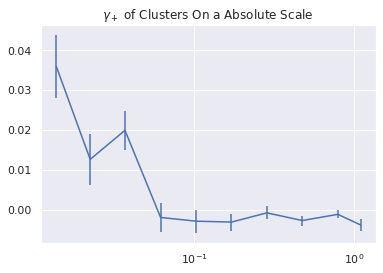

Aggregated xi:
[-26.1379 -23.763  -59.4547  10.2632  30.2265  62.3768  28.4058 189.0698
 140.1417 235.1758]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -3113.8159  -7114.5361  -9820.7832 -15322.5403 -24567.9555 -36383.3823
 -50202.6574 -53243.3956 -29787.8933   6259.0037]
------------------------------------------------------------------------------
Aggregated npairs:
[   726.   1872.   2977.   5502.  10817.  20636.  40073.  71738. 129670.
  62830.]
------------------------------------------------------------------------------
Mean xi:
[-0.036  -0.0127 -0.02    0.0019  0.0028  0.003   0.0007  0.0026  0.0011
  0.0037]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.289  -3.8005 -3.2989 -2.7849 -2.2712 -1.7631 -1.2528 -0.7422 -0.2297
  0.0996]
------------------------------------------------------------------------------


In [30]:
plt_w_error(mean_abs[1],-mean_abs[0],sig_abs,r"$\gamma_+$ of Clusters On a Absolute Scale ")
print_data(sum_abs,mean_abs)

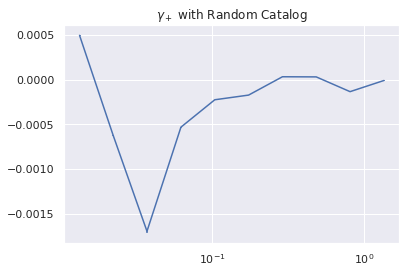

[ 4.9332e-04 -6.2438e-04 -1.6901e-03 -5.3002e-04 -2.2471e-04 -1.7261e-04
  3.1751e-05  3.0225e-05 -1.3427e-04 -1.0015e-05]
[-4.4173e-06  5.5909e-06  1.5134e-05  4.7459e-06  2.0121e-06  1.5456e-06
 -2.8431e-07 -2.7065e-07  1.2023e-06  8.9676e-08]


In [31]:
plt_w_error(r_meanlogr,-r_xi,r_sigma,r"$\gamma_+$ with Random Catalog")
print(-r_xi)
print(r_sigma)

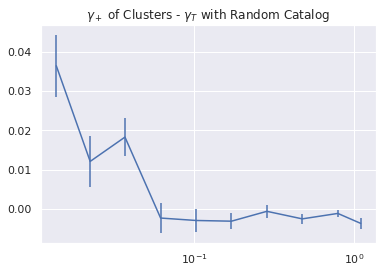

In [32]:
plt_w_error(mean_abs[1],-(mean_abs[0]+r_xi),np.hypot(r_sigma,sig_abs),r"$\gamma_+$ of Clusters - $\gamma_T$ with Random Catalog")

# Rel plots

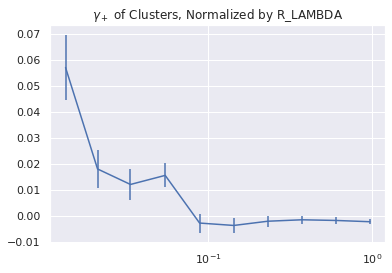

Aggregated xi:
[-13.8981 -20.0686 -24.9722 -52.7188  16.6875  42.6893  43.9418  59.7925
 119.4341 260.7097]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -1047.0681  -4287.8564  -7018.6706  -9840.6614 -14453.1012 -22297.5043
 -30786.4628 -38464.3288 -33984.5471  -3995.5543]
------------------------------------------------------------------------------
Aggregated npairs:
[   243.   1111.   2066.   3382.   5956.  11453.  20974.  38848.  66397.
 113847.]
------------------------------------------------------------------------------
Mean xi:
[-0.0572 -0.0181 -0.0121 -0.0156  0.0028  0.0037  0.0021  0.0015  0.0018
  0.0023]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.3089 -3.8595 -3.3972 -2.9097 -2.4266 -1.9469 -1.4678 -0.9901 -0.5118
 -0.0351]
------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [33]:
plt_w_error(mean_rel[1],-mean_rel[0],sig_rel,r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA")
print_data(sum_rel,mean_rel)